# AutoGluon 모델 기반 경제지표를 이용한 경기 흐름 예측

# [0] 데이터 분석 준비

### 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 코랩 환경 한글 글꼴 설치, 설치 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,608 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and dire

### 서드파티 모듈 설치

In [1]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

### 모듈 로드

In [4]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.rc('font', family='NanumBarunGothic')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

### 데이터 로드

In [6]:
eco_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/경제지표데이터/finance_final_68.csv', encoding = 'utf-8')

In [7]:
eco_df

,날짜,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,2003-01-01,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,2003-02-01,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000
2,2003-03-01,53.8,-1.8,98.5,87.6,7904.5,149.7,591.1,0.72,57.7,...,106.39,82,87,97.0,1,1.25,1.573810,2.783810,3.807143,4.816190
3,2003-04-01,53.7,-6.2,97.5,86.3,7858.6,150.3,576.1,0.61,57.6,...,106.39,71,45,91.0,0,1.26,1.622381,2.928571,3.958571,4.911905
4,2003-05-01,53.7,-8.5,95.5,85.4,7624.8,151.2,583.4,0.53,57.8,...,106.39,71,45,91.0,1,1.26,1.415238,2.515714,3.569048,4.521429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-05-01,109.8,-17.2,93.2,99.9,10466.3,84.5,2488.4,-0.15,110.3,...,96.52,64,88,98.0,1,5.06,4.131818,3.591364,3.573636,3.963636
245,2023-06-01,110.5,-13.0,94.6,99.0,11826.5,86.0,2548.9,-0.16,110.3,...,101.64,69,89,100.7,1,5.08,4.639524,3.949524,3.748095,4.041905
246,2023-07-01,111.1,-9.6,94.7,99.3,12177.8,86.6,2572.6,-0.04,110.0,...,102.08,75,91,103.2,1,5.12,4.828500,4.141500,3.899500,4.149500
247,2023-08-01,111.4,-7.9,94.6,98.4,9882.9,86.8,2585.1,0.12,110.0,...,99.03,72,91,103.1,1,5.33,4.901739,4.306522,4.167826,4.456522


### NA 처리

In [8]:
eco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   날짜                          249 non-null    object 
 1   선행종합지수(2020=100)            249 non-null    float64
 2   재고순환지표(%p)                  249 non-null    float64
 3   경제심리지수                      249 non-null    float64
 4   기계류내수출하지수(선박제외)(2020=100)   249 non-null    float64
 5   건설수주액(실질)(십억원)              249 non-null    float64
 6   수출입물가비율(2015=100)           249 non-null    float64
 7   코스피(1980.1.4=100)           249 non-null    float64
 8   장단기금리차(%p)                  249 non-null    float64
 9   동행종합지수(2020=100)            249 non-null    float64
 10  광공업생산지수(2020=100)           249 non-null    float64
 11  서비스업생산지수(도소매업제외)(2020=100)  249 non-null    float64
 12  건설기성액(실질)(십억원)              249 non-null    float64
 13  소매판매액지수(2020=100)           249 non

In [9]:
# fillna
#eco_df = eco_df.fillna(method = 'bfill').fillna(method = 'ffill')

### 수치형 변수만 사용

In [10]:
eco_num_df = eco_df.select_dtypes(include=['number'])
eco_num_df.head(2)

,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),광공업생산지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,51.6,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,51.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000


# [1] Random Forest Regressor를 이용한 피쳐 중요도 파악
- 종속변수 : 기준금리
- 독립변수 : 기준금리 외 다른 변수

### 학습 준비

- target, X 분리

In [11]:
target = eco_num_df['기준금리']
eco_df_for_lr = eco_num_df.drop(['기준금리'], axis = 1)

- Scaling

    - % 단위의 칼럼 + 기타 : MinMaxScaler
    - 일반 수치형, 100기준 칼럼 : StandardScaler

- % 단위 칼럼 : ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy', ' '미_coremom', '미_coreyoy', '콜금리', '미_금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20' 재고순환지표(%p), 장단기금리차(%p), CP유통수익률(%p), GDP 성장률 (%)]
<br/>

- 100기준 칼럼 : [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스'
,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)'
,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
<br/>

- 금액/인원 단위 칼럼 : ['건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)']

<br/>
- 기타 : ['미_cpi','미_corecpi', 'South Korea', 'United States of America']

In [12]:
std_cols =   [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스' ,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)' ,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
std_scaler = StandardScaler()
eco_df_for_lr[std_cols] = std_scaler.fit_transform(eco_df_for_lr[std_cols])

In [13]:
minmax_cols = ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy',  '미_coremom', '미_coreyoy', '콜금리', '미_금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20', '재고순환지표(%p)', '장단기금리차(%p)', 'CP유통수익률(%p)', 'GDP 성장률 (%)', '건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)','미_cpi','미_corecpi', 'South Korea', 'United States of America']
minmax_scaler = MinMaxScaler()
eco_df_for_lr[minmax_cols] = minmax_scaler.fit_transform(eco_df_for_lr[minmax_cols])

## Check VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")
    return vif_data

In [15]:
# VIF 확인

vif_df = calculate_vif(eco_df_for_lr)
print(vif_df)

                      feature       VIF
0            선행종합지수(2020=100)  39789.68
1                  재고순환지표(%p)    202.69
2                      경제심리지수     44.60
3   기계류내수출하지수(선박제외)(2020=100)     42.35
4              건설수주액(실질)(십억원)     74.24
..                        ...       ...
59                       미_금리    255.22
60                      미국채_2    847.54
61                      미국채_5   4990.81
62                     미국채_10  15210.08
63                     미국채_20   6604.66

[64 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [16]:
vif_df['VIF'] = vif_df['VIF'].astype(float)  # 실수형으로 변환

- VIF가 inf인 칼럼들은 제거합니다.

In [17]:
vif_df[vif_df['VIF'] >= 1000]['feature'].tolist()

['선행종합지수(2020=100)',
 '동행종합지수(2020=100)',
 '광공업생산지수(2020=100)',
 '서비스업생산지수(도소매업제외)(2020=100)',
 '수입액(실질)(백만불)',
 '비농림어업취업자수(천명)',
 '후행종합지수(2020=100)',
 '생산자제품재고지수(2020=100)',
 '소비재수입액(실질)(백만불)',
 '취업자수(천명)',
 '실업률총계',
 '국내총생산(GDP)(당해년 가격) (10억원\\)',
 '1인당 GDP(당해년 가격) (만원)',
 '소비자물가지수',
 '농산물및석유류제외지수',
 '식료품 및 에너지제외 지수',
 '미_cpi',
 '미_corecpi',
 '미국채_5',
 '미국채_10',
 '미국채_20']

In [18]:
high_vif_columns = vif_df[vif_df['VIF'] >= 1000]['feature'].tolist()
high_vif_columns

['선행종합지수(2020=100)',
 '동행종합지수(2020=100)',
 '광공업생산지수(2020=100)',
 '서비스업생산지수(도소매업제외)(2020=100)',
 '수입액(실질)(백만불)',
 '비농림어업취업자수(천명)',
 '후행종합지수(2020=100)',
 '생산자제품재고지수(2020=100)',
 '소비재수입액(실질)(백만불)',
 '취업자수(천명)',
 '실업률총계',
 '국내총생산(GDP)(당해년 가격) (10억원\\)',
 '1인당 GDP(당해년 가격) (만원)',
 '소비자물가지수',
 '농산물및석유류제외지수',
 '식료품 및 에너지제외 지수',
 '미_cpi',
 '미_corecpi',
 '미국채_5',
 '미국채_10',
 '미국채_20']

In [19]:
eco_df_for_lr = eco_df_for_lr.drop(high_vif_columns, axis=1)

In [20]:
vif_df = calculate_vif(eco_df_for_lr)
print(vif_df)

                      feature     VIF
0                  재고순환지표(%p)   51.87
1                      경제심리지수   26.98
2   기계류내수출하지수(선박제외)(2020=100)   15.99
3              건설수주액(실질)(십억원)   28.04
4           수출입물가비율(2015=100)   65.86
5           코스피(1980.1.4=100)   69.96
6                  장단기금리차(%p)   48.26
7              건설기성액(실질)(십억원)   77.34
8           소매판매액지수(2020=100)  155.67
9            내수출하지수(2020=100)  117.24
10            소비자물가지수변화율(서비스)   72.80
11                CP유통수익률(%p)  139.47
12                   실_15-19세   14.60
13                   실_20-29세  139.80
14                   실_30-39세  132.88
15                   실_40-49세   87.13
16                   실_50-59세   61.52
17                    실_60세이상    4.84
18                       경제위기    7.54
19                GDP 성장률 (%)   54.14
20                      원달러환율    9.10
21                      달러인덱스   29.98
22                  미_경기침체데이터    6.12
23                      미_실업률   26.42
24                      미_mom   77.81
25          

In [21]:
vif_df['VIF'] = vif_df['VIF'].astype(float)  # 실수형으로 변환
high_vif_columns = vif_df[vif_df['VIF'] >= 100]['feature'].tolist()
high_vif_columns

['소매판매액지수(2020=100)',
 '내수출하지수(2020=100)',
 'CP유통수익률(%p)',
 '실_20-29세',
 '실_30-39세',
 '콜금리',
 'BSI_전산업',
 'BSI_제조업',
 'BSI_비제조업']

In [22]:
eco_df_for_lr = eco_df_for_lr.drop(high_vif_columns, axis=1)

### 모델 학습

In [23]:
rf = RandomForestRegressor()

rf.fit(eco_df_for_lr, target)

RandomForestRegressor()

### 피쳐중요도 확인

In [24]:
# 피쳐 중요도 확인
feature_importances = rf.feature_importances_

# 피쳐 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 각 피쳐의 중요도 출력
for f in range(eco_df_for_lr.shape[1]):
    print(f"{eco_df_for_lr.columns[indices[f]]}: {feature_importances[indices[f]]}")

달러인덱스: 0.41199787753114403
미국채_2: 0.17932752469490426
소비자물가지수변화율(서비스): 0.11442049167893556
미_금리: 0.09114871026334519
건설수주액(실질)(십억원): 0.02587692195689594
현재생활형편: 0.025676098986305542
수출입물가비율(2015=100): 0.025572651174299358
기계류내수출하지수(선박제외)(2020=100): 0.020000632709437114
건설기성액(실질)(십억원): 0.019535632989687256
GDP 성장률 (%): 0.017644177437205963
장단기금리차(%p): 0.012365302285857756
실_60세이상: 0.010787714008686396
미_coremom: 0.008730558068850971
원달러환율: 0.006012302118336428
미_yoy: 0.005347347292953944
재고순환지표(%p): 0.004731676535069584
동행지수순환변동치: 0.004725566693843844
코스피(1980.1.4=100): 0.0040218563402555025
미_실업률: 0.0032574319923633697
경제위기: 0.0017320383888790004
현재경기판단: 0.0008722938634630281
경제심리지수: 0.0008721345393278085
South Korea: 0.000732286247922124
선행지수순환변동치: 0.0006985818971199955
뉴스심리지수: 0.0006187439052014396
실_15-19세: 0.0005955787146631369
소비자심리지수(CCSI): 0.0004780902654446885
실_40-49세: 0.00043190764453581517
미_mom: 0.0003998194669743201
미_coreyoy: 0.0003814537833078855
미_경기침체데이터: 0.00034738949

### 피쳐 Selection

- 랜덤포래스트 학습 결과 상위 20개 피쳐
- EDA를 바탕으로 높은 연관성을 보이는 피쳐 직접 추가

In [25]:
top_20_features = eco_df_for_lr.columns[indices[:20]].tolist() #+ ['경제심리지수','소비자물가지수변화율(서비스)', '뉴스심리지수','현재경기판단']

top_20_features

['달러인덱스',
 '미국채_2',
 '소비자물가지수변화율(서비스)',
 '미_금리',
 '건설수주액(실질)(십억원)',
 '현재생활형편',
 '수출입물가비율(2015=100)',
 '기계류내수출하지수(선박제외)(2020=100)',
 '건설기성액(실질)(십억원)',
 'GDP 성장률 (%)',
 '장단기금리차(%p)',
 '실_60세이상',
 '미_coremom',
 '원달러환율',
 '미_yoy',
 '재고순환지표(%p)',
 '동행지수순환변동치',
 '코스피(1980.1.4=100)',
 '미_실업률',
 '경제위기']

# [2] 시계열 분석

- 회귀분석 피쳐중요도 바탕으로 시계열 예측

### 전처리

In [26]:
eco_df_for_ts = eco_df_for_lr[top_20_features]

In [27]:
eco_df_for_ts

,달러인덱스,미국채_2,소비자물가지수변화율(서비스),미_금리,건설수주액(실질)(십억원),현재생활형편,수출입물가비율(2015=100),기계류내수출하지수(선박제외)(2020=100),건설기성액(실질)(십억원),GDP 성장률 (%),장단기금리차(%p),실_60세이상,미_coremom,원달러환율,미_yoy,재고순환지표(%p),동행지수순환변동치,코스피(1980.1.4=100),미_실업률,경제위기
0,-0.152880,0.325188,0.682927,0.225379,0.226746,0.314397,2.410149,-0.970088,0.250147,0.647619,0.393651,0.03,0.224837,-0.555207,0.433008,0.435943,1.062010,-2.143180,0.212389,1
1,-0.180872,0.302130,0.731707,0.229167,0.218983,0.314397,2.447482,-1.098516,0.239756,0.647619,0.346032,0.01,0.197885,0.607611,0.468688,0.427046,0.673983,-2.159945,0.221239,1
2,-0.208015,0.291327,0.804878,0.227273,0.207423,0.314397,2.490147,-1.217064,0.234879,0.647619,0.307937,0.02,0.188977,1.180553,0.457591,0.411032,0.382963,-2.166788,0.221239,1
3,-0.325919,0.301029,0.878049,0.229167,0.203746,-2.554682,2.522146,-1.345491,0.219194,0.466667,0.273016,0.02,0.144580,0.810822,0.379543,0.332740,-0.199078,-2.192449,0.230088,1
4,-0.386992,0.259655,0.902439,0.229167,0.185016,-2.554682,2.570145,-1.434403,0.225174,0.466667,0.247619,0.01,0.152907,0.722388,0.353746,0.291815,-0.199078,-2.179961,0.238938,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.519423,0.802259,0.902439,0.948864,0.412651,0.382708,-0.987089,-0.001944,0.784433,0.333333,0.031746,0.13,0.782406,1.863568,0.558919,0.137011,0.285956,1.079000,0.026549,0
245,1.507138,0.903667,0.853659,0.952652,0.521618,0.451020,-0.907091,-0.090855,0.781909,0.333333,0.028571,0.14,0.704976,1.774193,0.463724,0.211744,0.091942,1.182500,0.017699,0
246,1.411663,0.941413,0.780488,0.960227,0.549761,0.587643,-0.875092,-0.061218,0.773429,0.476190,0.066667,0.14,0.679147,1.368712,0.482736,0.272242,-0.393092,1.223044,0.008850,0
247,1.563828,0.956042,0.731707,1.000000,0.365914,0.587643,-0.864426,-0.150129,0.786026,0.476190,0.117460,0.05,0.626984,1.812765,0.520235,0.302491,-0.587105,1.244428,0.035398,0


- AutoGluon 타임시리즈 예측을 위한 처리
    - 날짜를 나타내는 'timestamp' 칼럼과 각 값을 구분하는 'item' 칼럼이 반드시 필요
    - item은 여기서 0으로 통일해도 무방하다.

In [183]:
eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
eco_df_for_ts['item_id'] = 0
eco_df_for_ts['기준금리'] = target

<ipython-input-183-62d32f1e6880>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
<ipython-input-183-62d32f1e6880>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['item_id'] = 0
<ipython-input-183-62d32f1e6880>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [184]:
eco_df_for_ts

,달러인덱스,미국채_2,소비자물가지수변화율(서비스),미_금리,건설수주액(실질)(십억원),현재생활형편,수출입물가비율(2015=100),기계류내수출하지수(선박제외)(2020=100),건설기성액(실질)(십억원),GDP 성장률 (%),...,원달러환율,미_yoy,재고순환지표(%p),동행지수순환변동치,코스피(1980.1.4=100),미_실업률,경제위기,timestamp,item_id,기준금리
0,-0.152880,0.325188,0.682927,0.225379,0.226746,0.314397,2.410149,-0.970088,0.250147,0.647619,...,-0.555207,0.433008,0.435943,1.062010,-2.143180,0.212389,1,2003-01-01,0,4.25
1,-0.180872,0.302130,0.731707,0.229167,0.218983,0.314397,2.447482,-1.098516,0.239756,0.647619,...,0.607611,0.468688,0.427046,0.673983,-2.159945,0.221239,1,2003-02-01,0,4.25
2,-0.208015,0.291327,0.804878,0.227273,0.207423,0.314397,2.490147,-1.217064,0.234879,0.647619,...,1.180553,0.457591,0.411032,0.382963,-2.166788,0.221239,1,2003-03-01,0,4.25
3,-0.325919,0.301029,0.878049,0.229167,0.203746,-2.554682,2.522146,-1.345491,0.219194,0.466667,...,0.810822,0.379543,0.332740,-0.199078,-2.192449,0.230088,1,2003-04-01,0,4.25
4,-0.386992,0.259655,0.902439,0.229167,0.185016,-2.554682,2.570145,-1.434403,0.225174,0.466667,...,0.722388,0.353746,0.291815,-0.199078,-2.179961,0.238938,1,2003-05-01,0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.519423,0.802259,0.902439,0.948864,0.412651,0.382708,-0.987089,-0.001944,0.784433,0.333333,...,1.863568,0.558919,0.137011,0.285956,1.079000,0.026549,0,2023-05-01,0,3.50
245,1.507138,0.903667,0.853659,0.952652,0.521618,0.451020,-0.907091,-0.090855,0.781909,0.333333,...,1.774193,0.463724,0.211744,0.091942,1.182500,0.017699,0,2023-06-01,0,3.50
246,1.411663,0.941413,0.780488,0.960227,0.549761,0.587643,-0.875092,-0.061218,0.773429,0.476190,...,1.368712,0.482736,0.272242,-0.393092,1.223044,0.008850,0,2023-07-01,0,3.50
247,1.563828,0.956042,0.731707,1.000000,0.365914,0.587643,-0.864426,-0.150129,0.786026,0.476190,...,1.812765,0.520235,0.302491,-0.587105,1.244428,0.035398,0,2023-08-01,0,3.50


### 3개월 단위 예측

#### - Validation : [MSE : 0.0001]

- train test split

In [185]:
train = eco_df_for_ts.iloc[: 246, :]
test = eco_df_for_ts.iloc[246 :, :]

train.shape, test.shape

((246, 23), (3, 23))

In [186]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2023-02-01  1.558476  0.882527         0.926829  0.856061   
        2023-03-01  1.600073  0.836373         0.902439  0.871212   
        2023-04-01  1.482362  0.779126         0.926829  0.905303   
        2023-05-01  1.519423  0.802259         0.902439  0.948864   
        2023-06-01  1.507138  0.903667         0.853659  0.952652   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2023-02-01        0.740529 -0.027160          -0.981756   
        2023-03-01        0.691437  0.041151          -0.992422   
        2023-04-01        0.410600  0.314397          -0.987089   
        2023-05-01        0.412651  0.382708          -0.987089   
        2023-06-01        0.521618  0.451020          -0.907091   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2023-02-01                   0.738983        0.766641     0.333333   
        2023-03-01                   0.294427        0.801662     0.333333   
        2023-04-01                   0.136362        0.804750     0.333333   
        2023-05-01                  -0.001944        0.784433     0.333333   
        2023-06-01                  -0.090855        0.781909     0.333333   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2023-02-01  ...     0.22   0.815081  1.820291  0.729470    0.154804   
        2023-03-01  ...     0.12   0.827757  1.625548  0.637701    0.149466   
        2023-04-01  ...     0.11   0.816845  1.962351  0.634972    0.144128   
        2023-05-01  ...     0.13   0.782406  1.863568  0.558919    0.137011   
        2023-06-01  ...     0.14   0.704976  1.774193  0.463724    0.211744   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

- AutoGluon 자동화 시계열 예측 모델 학습

In [187]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_134559'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       47.56 GB / 51.00 GB (93.3%)
Disk Space Avail:   128.62 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 246 rows, 1 time series. Median time series length is 246 (min=246, max=246). 

Provided dat

- 전체 데이터를 대상으로 다시 학습

In [188]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- valid 예측

In [189]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [190]:
# 원래값
test['기준금리']

246    3.5
247    3.5
248    3.5
Name: 기준금리, dtype: float64

In [191]:
# 예측값
pred.reset_index()['mean']

0    3.506560
1    3.512494
2    3.516483
Name: mean, dtype: float64

In [192]:
valid_3 = pred.reset_index()['mean']

In [193]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.0002

In [194]:
eco_df_for_ts

,달러인덱스,미국채_2,소비자물가지수변화율(서비스),미_금리,건설수주액(실질)(십억원),현재생활형편,수출입물가비율(2015=100),기계류내수출하지수(선박제외)(2020=100),건설기성액(실질)(십억원),GDP 성장률 (%),...,원달러환율,미_yoy,재고순환지표(%p),동행지수순환변동치,코스피(1980.1.4=100),미_실업률,경제위기,timestamp,item_id,기준금리
0,-0.152880,0.325188,0.682927,0.225379,0.226746,0.314397,2.410149,-0.970088,0.250147,0.647619,...,-0.555207,0.433008,0.435943,1.062010,-2.143180,0.212389,1,2003-01-01,0,4.25
1,-0.180872,0.302130,0.731707,0.229167,0.218983,0.314397,2.447482,-1.098516,0.239756,0.647619,...,0.607611,0.468688,0.427046,0.673983,-2.159945,0.221239,1,2003-02-01,0,4.25
2,-0.208015,0.291327,0.804878,0.227273,0.207423,0.314397,2.490147,-1.217064,0.234879,0.647619,...,1.180553,0.457591,0.411032,0.382963,-2.166788,0.221239,1,2003-03-01,0,4.25
3,-0.325919,0.301029,0.878049,0.229167,0.203746,-2.554682,2.522146,-1.345491,0.219194,0.466667,...,0.810822,0.379543,0.332740,-0.199078,-2.192449,0.230088,1,2003-04-01,0,4.25
4,-0.386992,0.259655,0.902439,0.229167,0.185016,-2.554682,2.570145,-1.434403,0.225174,0.466667,...,0.722388,0.353746,0.291815,-0.199078,-2.179961,0.238938,1,2003-05-01,0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.519423,0.802259,0.902439,0.948864,0.412651,0.382708,-0.987089,-0.001944,0.784433,0.333333,...,1.863568,0.558919,0.137011,0.285956,1.079000,0.026549,0,2023-05-01,0,3.50
245,1.507138,0.903667,0.853659,0.952652,0.521618,0.451020,-0.907091,-0.090855,0.781909,0.333333,...,1.774193,0.463724,0.211744,0.091942,1.182500,0.017699,0,2023-06-01,0,3.50
246,1.411663,0.941413,0.780488,0.960227,0.549761,0.587643,-0.875092,-0.061218,0.773429,0.476190,...,1.368712,0.482736,0.272242,-0.393092,1.223044,0.008850,0,2023-07-01,0,3.50
247,1.563828,0.956042,0.731707,1.000000,0.365914,0.587643,-0.864426,-0.150129,0.786026,0.476190,...,1.812765,0.520235,0.302491,-0.587105,1.244428,0.035398,0,2023-08-01,0,3.50


In [195]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[246:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[246: , :]

<ipython-input-196-5f2e605e88a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


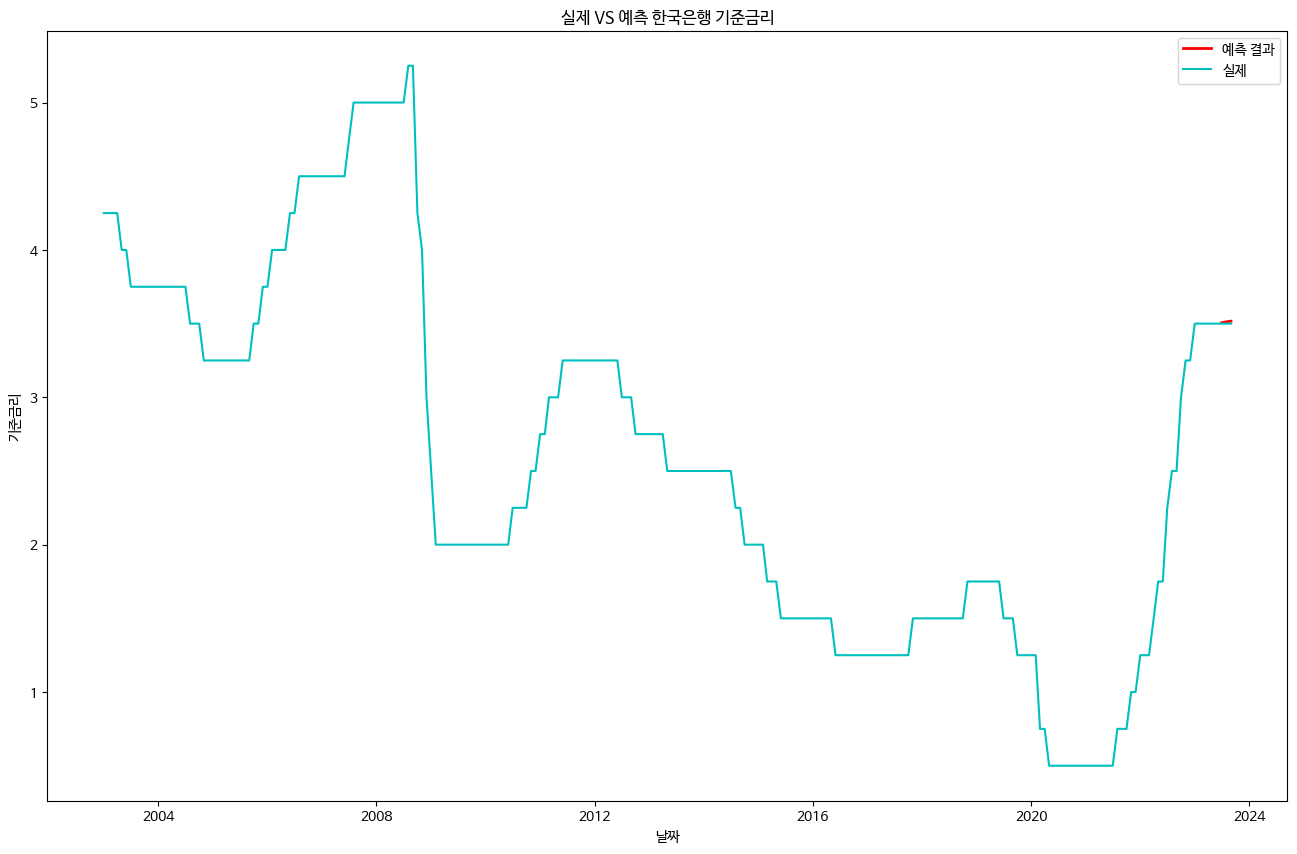

In [196]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [197]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_134845'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.58 GB / 51.00 GB (91.3%)
Disk Space Avail:   128.61 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided dat

In [198]:
pred_3 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [199]:
for_plot_3 = pred_3.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [200]:
for_plot_3

,날짜,mean
0,2023-10-01,3.499402
1,2023-11-01,3.499449
2,2023-12-01,3.495574


<ipython-input-201-2f1fce5b0813>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


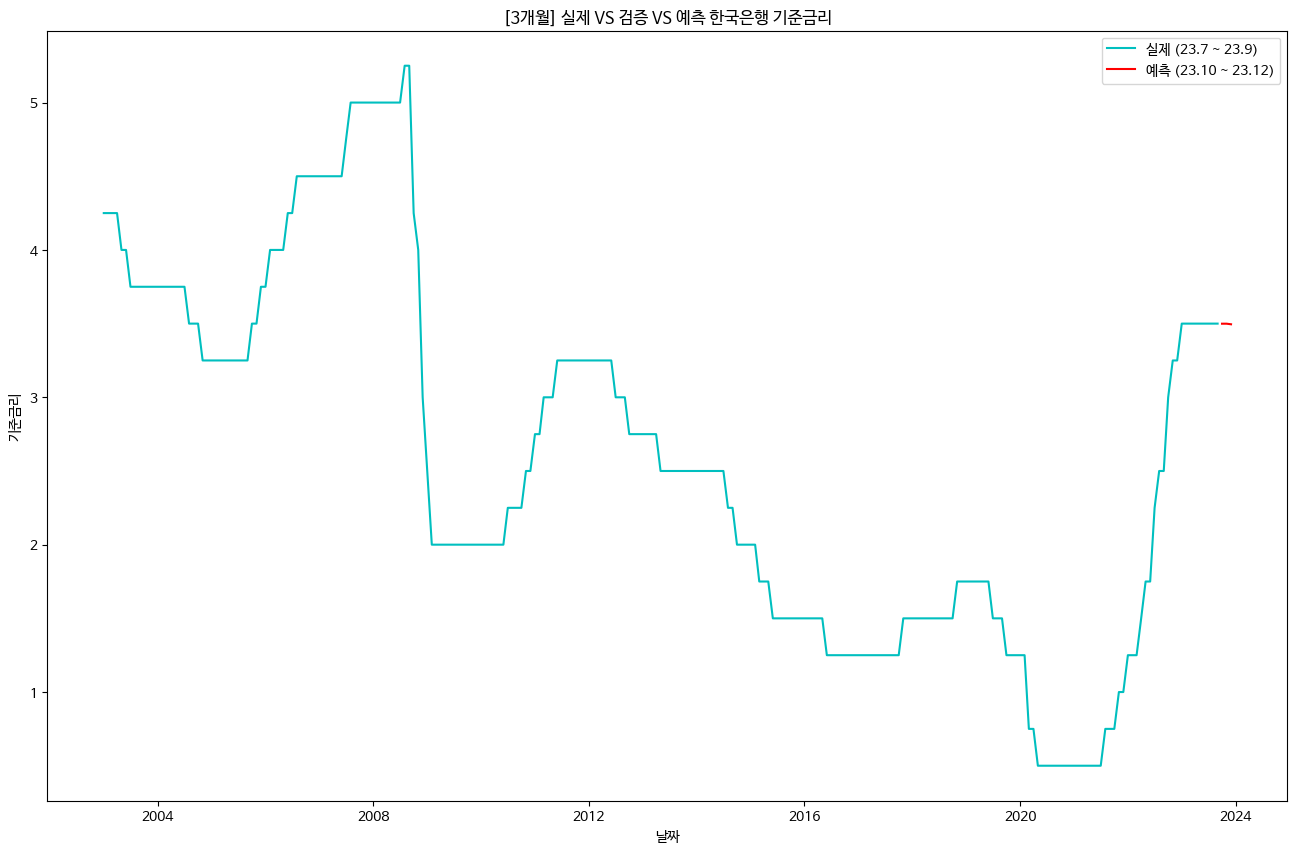

In [201]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_3['날짜'], for_plot_3['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[3개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 3개월 검증결과 큰 차이가 없음 (실제로 3.5 현행 유지중)
- 향후 3개월간 유지 예측 (10월 ~ 12월)

### 6개월 단위 예측 [MSE : 0.3936]

#### Validation

- train test split

In [202]:
train = eco_df_for_ts.iloc[: 243, :]
test = eco_df_for_ts.iloc[243 :, :]

train.shape, test.shape

((243, 23), (6, 23))

In [203]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2022-11-01  1.940118  0.876498         1.000000  0.706439   
        2022-12-01  1.718496  0.833569         0.975610  0.767045   
        2023-01-01  1.512746  0.817376         0.951220  0.810606   
        2023-02-01  1.558476  0.882527         0.926829  0.856061   
        2023-03-01  1.600073  0.836373         0.902439  0.871212   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2022-11-01        0.653617  0.041151          -0.960423   
        2022-12-01        0.426695  0.041151          -0.949756   
        2023-01-01        0.686142 -0.027160          -0.955090   
        2023-02-01        0.740529 -0.027160          -0.981756   
        2023-03-01        0.691437  0.041151          -0.992422   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2022-11-01                   1.677490        0.669836     0.380952   
        2022-12-01                   1.647853        0.688388     0.380952   
        2023-01-01                   1.084749        0.709906     0.333333   
        2023-02-01                   0.738983        0.766641     0.333333   
        2023-03-01                   0.294427        0.801662     0.333333   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2022-11-01  ...     0.05   0.888915  1.784541  0.834954    0.309609   
        2022-12-01  ...     0.44   0.844526  1.273692  0.771566    0.258007   
        2023-01-01  ...     0.56   0.818653  0.966994  0.762588    0.169039   
        2023-02-01  ...     0.22   0.815081  1.820291  0.729470    0.154804   
        2023-03-01  ...     0.12   0.827757  1.625548  0.637701    0.149466   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

- AutoGluon 자동화 시계열 예측 모델 학습

In [204]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_134948'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.42 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.61 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 243 rows, 1 time series. Median time series length is 243 (min=243, max=243). 

Provided dat

- 전체 데이터를 대상으로 다시 학습

In [205]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [206]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [207]:
# 원래값
test['기준금리']

243    3.5
244    3.5
245    3.5
246    3.5
247    3.5
248    3.5
Name: 기준금리, dtype: float64

In [208]:
# 예측값
valid_6 = pred.reset_index()['mean']
pred.reset_index()['mean']

0    2.625232
1    2.786566
2    2.694710
3    3.029205
4    3.226425
5    3.106534
Name: mean, dtype: float64

In [209]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.3957

In [210]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[243:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[243: , :]

<ipython-input-211-ce23139bd83f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


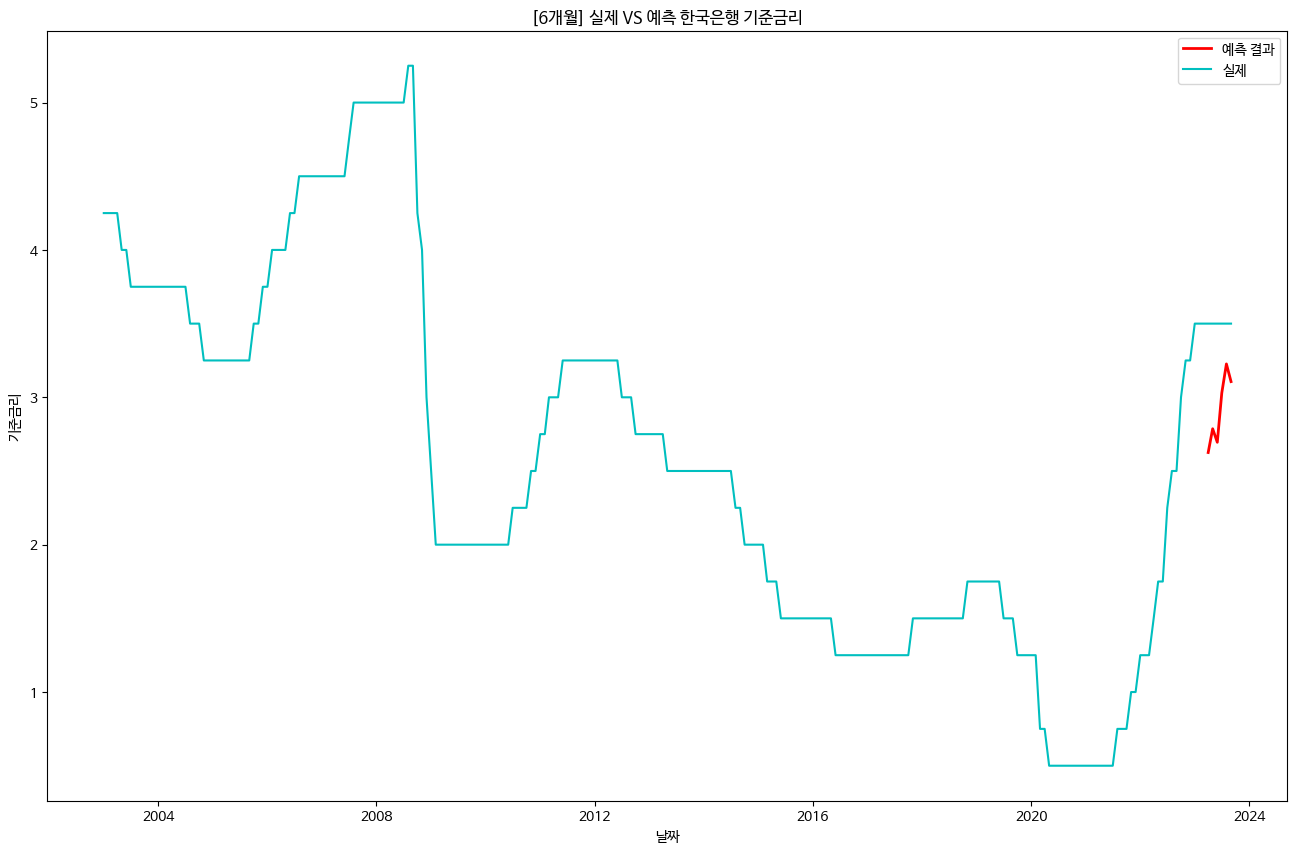

In [211]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[6개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [212]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_134956'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.43 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.60 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided dat

In [213]:
pred_6 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [214]:
for_plot_6 = pred_6.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [215]:
for_plot_6

,날짜,mean
0,2023-10-01,3.512280
1,2023-11-01,3.513914
2,2023-12-01,3.511042
3,2024-01-01,3.515321
4,2024-02-01,3.517859
5,2024-03-01,3.517821


<ipython-input-216-caf64ee4b889>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


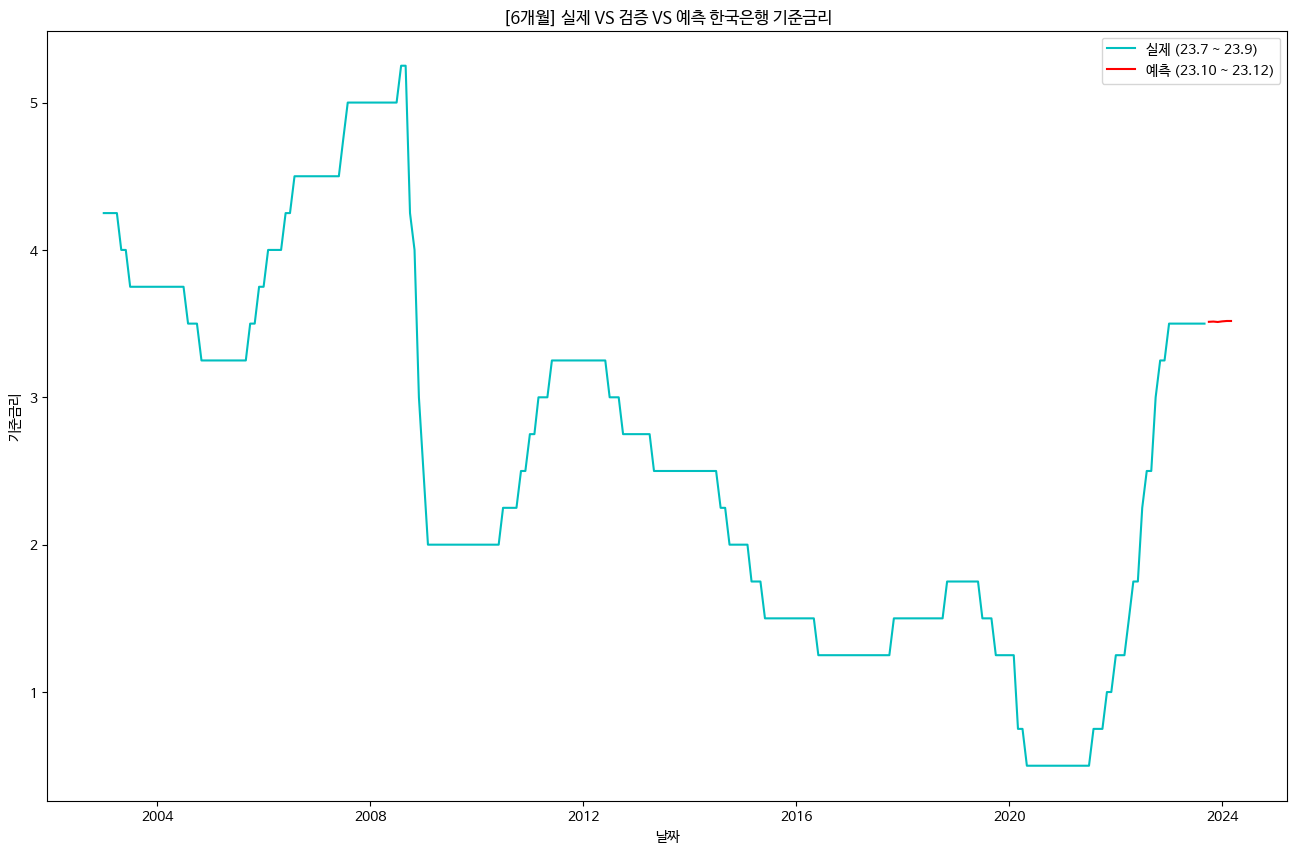

In [216]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_6['날짜'] = pd.to_datetime(for_plot_6['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_6['날짜'], for_plot_6['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[6개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 6개월 검증결과 큰 차이가 없음
- 향후 6개월간 유지 예측 (10월 ~ 03월)

### 12개월 단위 예측 [MSE : 0.6921]

#### Validation

- train test split

In [217]:
train = eco_df_for_ts.iloc[: 237, :]
test = eco_df_for_ts.iloc[237 :, :]

train.shape, test.shape

((237, 23), (12, 23))

In [218]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2022-05-01  1.503286  0.499626         0.756098  0.136364   
        2022-06-01  1.528553  0.575812         0.829268  0.219697   
        2022-07-01  1.756344  0.583383         0.902439  0.308712   
        2022-08-01  1.721478  0.626127         0.951220  0.431818   
        2022-09-01  1.998820  0.747301         0.975610  0.475379   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2022-05-01        0.847028  0.451020          -0.949756   
        2022-06-01        0.920298  0.314397          -0.923091   
        2022-07-01        1.000000 -0.095471          -0.923091   
        2022-08-01        0.994576  0.041151          -0.923091   
        2022-09-01        0.993343  0.177774          -0.933757   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2022-05-01                   0.314185        0.532154     0.523810   
        2022-06-01                   0.403096        0.549946     0.523810   
        2022-07-01                   0.719225        0.567052     0.552381   
        2022-08-01                   1.094628        0.562592     0.552381   
        2022-09-01                   1.331724        0.573400     0.552381   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2022-05-01  ...     0.14   0.897024  1.016856  0.960460    0.261566   
        2022-06-01  ...     0.14   0.874502  1.592620  1.000000    0.204626   
        2022-07-01  ...     0.11   0.875228  1.599205  0.952275    0.174377   
        2022-08-01  ...     0.02   0.943305  1.961410  0.935215    0.177936   
        2022-09-01  ...     0.06   1.000000  2.832583  0.934066    0.261566   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

- AutoGluon 자동화 시계열 예측 모델 학습

In [219]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135006'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.41 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.60 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 237 rows, 1 time series. Median time series length is 237 (min=237, max=237). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [220]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [221]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [222]:
# 원래값
test['기준금리']

237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [223]:
# 예측값
valid_12 = pred.reset_index()['mean']

pred.reset_index()['mean']

0     2.040547
1     2.238507
2     2.252483
3     2.518450
4     2.522564
5     2.521860
6     2.677765
7     2.846161
8     2.829595
9     3.250384
10    3.461334
11    3.431491
Name: mean, dtype: float64

In [224]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.6197

In [225]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[237:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[237: , :]

<ipython-input-226-5f2e605e88a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


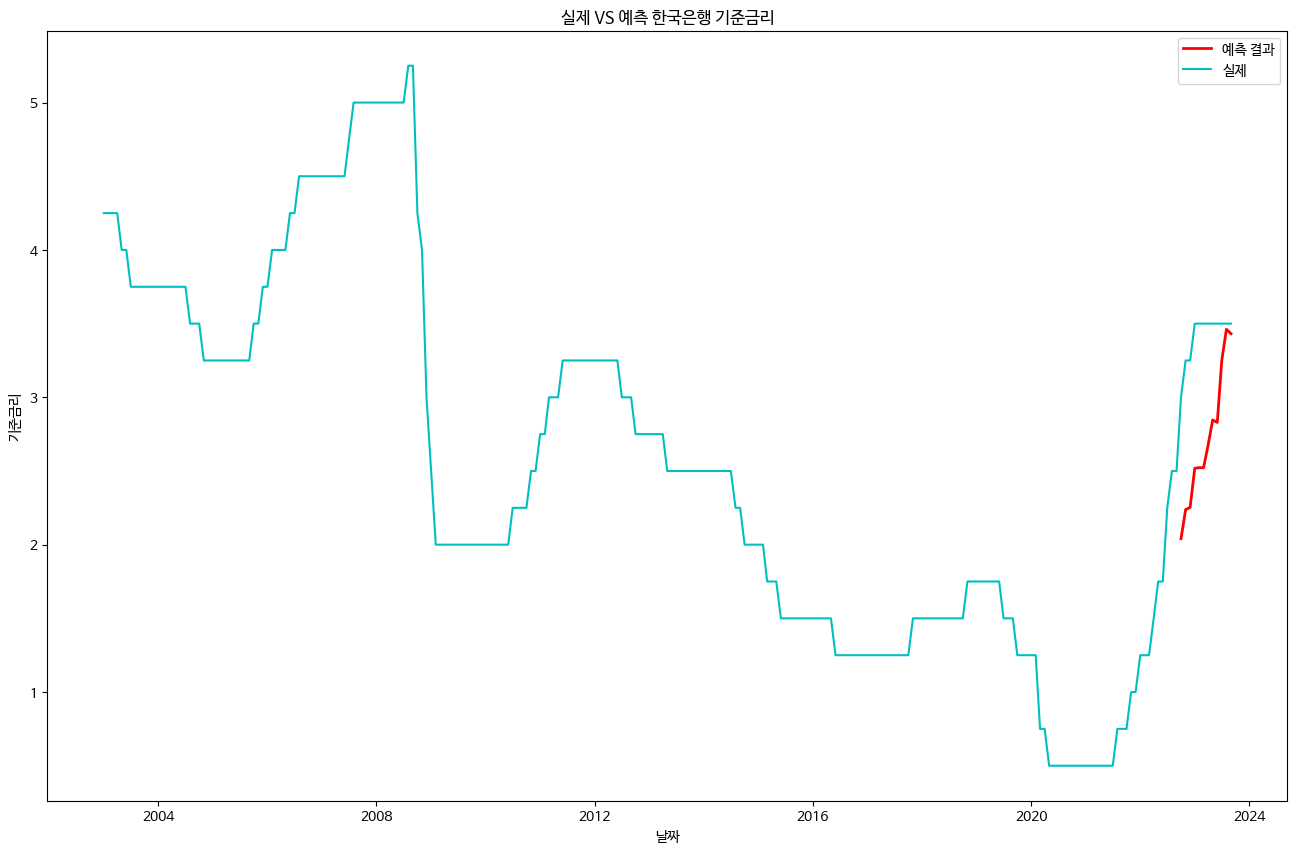

In [226]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [227]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135017'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.41 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.59 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [228]:
pred_12 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [229]:
for_plot_12 = pred_12.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [230]:
for_plot_12

,날짜,mean
0,2023-10-01,3.611118
1,2023-11-01,3.646149
2,2023-12-01,3.479068
3,2024-01-01,3.626589
4,2024-02-01,3.643641
5,2024-03-01,3.616816
6,2024-04-01,3.501292
7,2024-05-01,3.243704
8,2024-06-01,2.402579
9,2024-07-01,1.626975


<ipython-input-231-866e638018fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


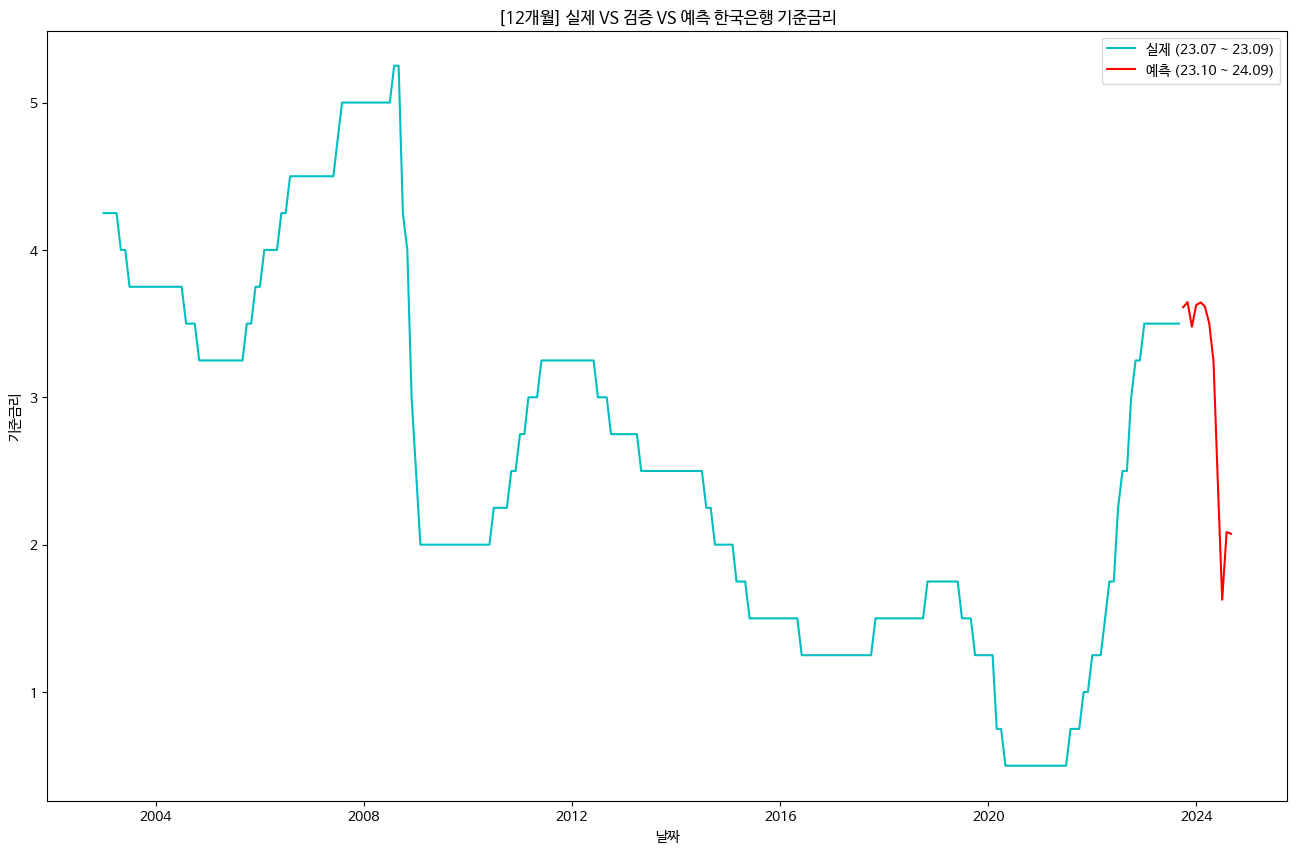

In [231]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_12['날짜'] = pd.to_datetime(for_plot_12['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.07 ~ 23.09)', c = 'c')
plt.plot(for_plot_12['날짜'], for_plot_12['mean'], label='예측 (23.10 ~ 24.09)', c = 'r')

plt.title('[12개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 12개 결과

### 18개월 단위 예측

- train test split

In [232]:
train = eco_df_for_ts.iloc[: 231, :]
test = eco_df_for_ts.iloc[231 :, :]

train.shape, test.shape

((231, 23), (18, 23))

In [233]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2021-11-01  1.107723  0.078445         0.609756  0.005682   
        2021-12-01  1.176581  0.112799         0.658537  0.005682   
        2022-01-01  1.111799  0.172821         0.609756  0.005682   
        2022-02-01  1.108697  0.263654         0.658537  0.005682   
        2022-03-01  1.223579  0.358391         0.707317  0.028409   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2021-11-01        0.723850  0.655954          -0.677764   
        2021-12-01        0.732029  0.587643          -0.715096   
        2022-01-01        0.782042  0.587643          -0.747096   
        2022-02-01        0.811908  0.519331          -0.821760   
        2022-03-01        0.894326  0.519331          -0.923091   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2021-11-01                   0.541402        0.496226     0.657143   
        2021-12-01                   0.561160        0.553328     0.657143   
        2022-01-01                   0.837773        0.600921     0.542857   
        2022-02-01                   0.788378        0.614719     0.542857   
        2022-03-01                   0.709346        0.558573     0.542857   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2021-11-01  ...     0.08   0.724560  0.553046  0.809893    0.286477   
        2021-12-01  ...     0.56   0.814532  0.561513  0.840381    0.270463   
        2022-01-01  ...     0.76   0.904945  0.718625  0.877182    0.290036   
        2022-02-01  ...     0.35   0.965493  0.688519  0.910194    0.295374   
        2022-03-01  ...     0.22   0.968456  0.780717  0.961643    0.295374   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [234]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")
#predictor.fit( data, random_seed=42, presets="best_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135025'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.42 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.59 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 231 rows, 1 time series. Median time series length is 231 (min=231, max=231). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [235]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [236]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [237]:
# 원래값
test['기준금리']

231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [238]:
# 예측값
valid_18 = pred.reset_index()['0.7']

pred.reset_index()['0.7']

0     1.317018
1     1.337850
2     1.343733
3     1.353404
4     1.447570
5     1.458618
6     1.465265
7     1.561120
8     1.573535
9     1.667022
10    1.675350
11    1.669351
12    1.710636
13    1.716905
14    1.706088
15    1.714751
16    1.807716
17    1.815569
Name: 0.7, dtype: float64

In [239]:
round(mean_squared_error(test['기준금리'],pred.reset_index()['0.7']), 4)

2.2173

In [240]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[231:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[231: , :]

<ipython-input-241-cb6f687c7cb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


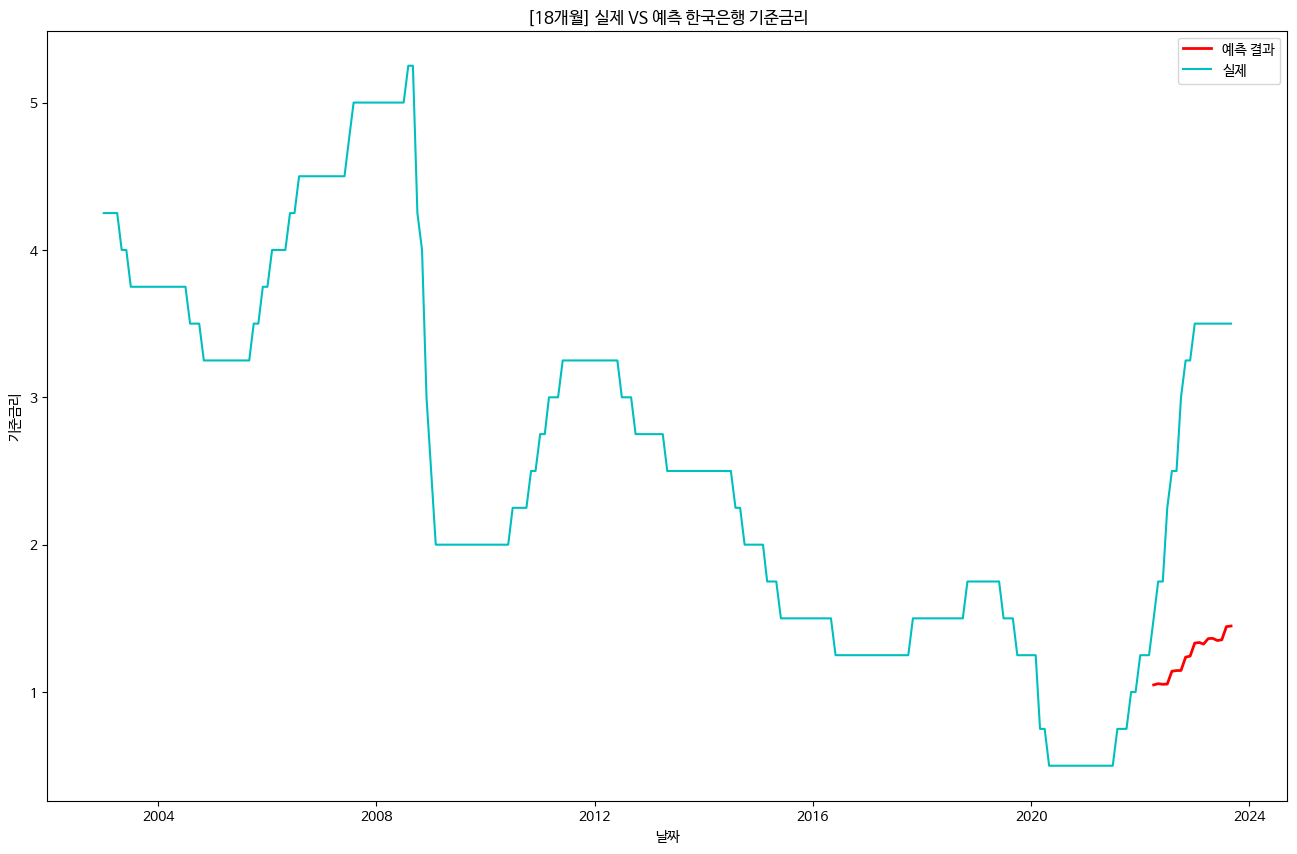

In [241]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [242]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")
#predictor.fit( eco_df_for_ts, random_seed=42, presets="high_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135034'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.41 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.58 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [243]:
pred_18 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [244]:
pred_18

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  4.062922  3.632323  3.777022  3.820138  3.899431   
        2023-11-01  4.219901  3.745596  3.872610  3.976037  4.070590   
        2023-12-01  4.041138  3.553075  3.656640  3.773771  3.922487   
        2024-01-01  3.993188  3.461424  3.581011  3.709695  3.825829   
        2024-02-01  3.990074  3.409974  3.543677  3.682539  3.807370   
        2024-03-01  3.922668  3.203506  3.434876  3.582940  3.715633   
        2024-04-01  3.666718  2.934597  3.220155  3.334228  3.474152   
        2024-05-01  3.290180  2.500344  2.839278  2.961227  3.107880   
        2024-06-01  3.116045  2.291230  2.640422  2.769768  2.922743   
        2024-07-01  2.834433  2.000455  2.316898  2.495694  2.612194   
        2024-08-01  3.192384  2.346380  2.629599  2.815049  3.022141   
        2024-09-01  3.042785  2.146895  2.481385  2.630742  2.885720   
        2024-10-01  3.666340  2.781047  3.081542  3.236997  3.412281   
        2024-11-01  3.556794  2.675387  2.941568  3.145344  3.325642   
        2024-12-01  3.343789  2.490452  2.722032  2.931470  3.074153   
        2025-01-01  3.500295  2.591296  2.830471  3.087838  3.277653   
        2025-02-01  3.461827  2.582753  2.829289  3.049511  3.201409   
        2025-03-01  3.348569  2.390088  2.728677  2.911601  3.110355   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  4.018771  4.095658  4.259857  4.345425  4.575030  
        2023-11-01  4.161740  4.295343  4.474802  4.535776  4.747696  
        2023-12-01  4.067034  4.169128  4.317844  4.392522  4.580993  
        2024-01-01  3.937150  4.090923  4.207057  4.420647  4.667593  
        2024-02-01  3.926820  4.131175  4.213553  4.437321  4.655929  
        2024-03-01  3.927337  4.096589  4.229282  4.419799  4.651169  
        2024-04-01  3.565256  3.783718  3.923642  4.207526  4.493084  
        2024-05-01  3.205274  3.345121  3.534228  3.825988  4.080016  
        2024-06-01  3.068498  3.256706  3.494586  3.666385  3.930672  
        2024-07-01  2.805989  2.957332  3.116285  3.379987  3.653977  
        2024-08-01  3.178799  3.335457  3.585001  3.770452  4.011218  
        2024-09-01  3.047455  3.166738  3.421716  3.613525  3.863110  
        2024-10-01  3.663793  3.830399  4.005683  4.246044  4.631444  
        2024-11-01  3.496935  3.710681  3.975884  4.137207  4.445841  
        2024-12-01  3.292421  3.510689  3.738278  3.947716  4.264202  
        2025-01-01  3.500295  3.680484  3.912752  4.127667  4.494200  
        2025-02-01  3.428290  3.570265  3.807068  4.112196  4.528543  
        2025-03-01  3.298899  3.487443  3.728650  3.996479  4.419974

In [245]:
for_plot_18 = pred_18.reset_index()[['timestamp','0.1']].rename(columns = {'timestamp' : '날짜'})

In [246]:
for_plot_18

,날짜,0.1
0,2023-10-01,3.632323
1,2023-11-01,3.745596
2,2023-12-01,3.553075
3,2024-01-01,3.461424
4,2024-02-01,3.409974
5,2024-03-01,3.203506
6,2024-04-01,2.934597
7,2024-05-01,2.500344
8,2024-06-01,2.291230
9,2024-07-01,2.000455


<ipython-input-247-ba61cc60dddc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


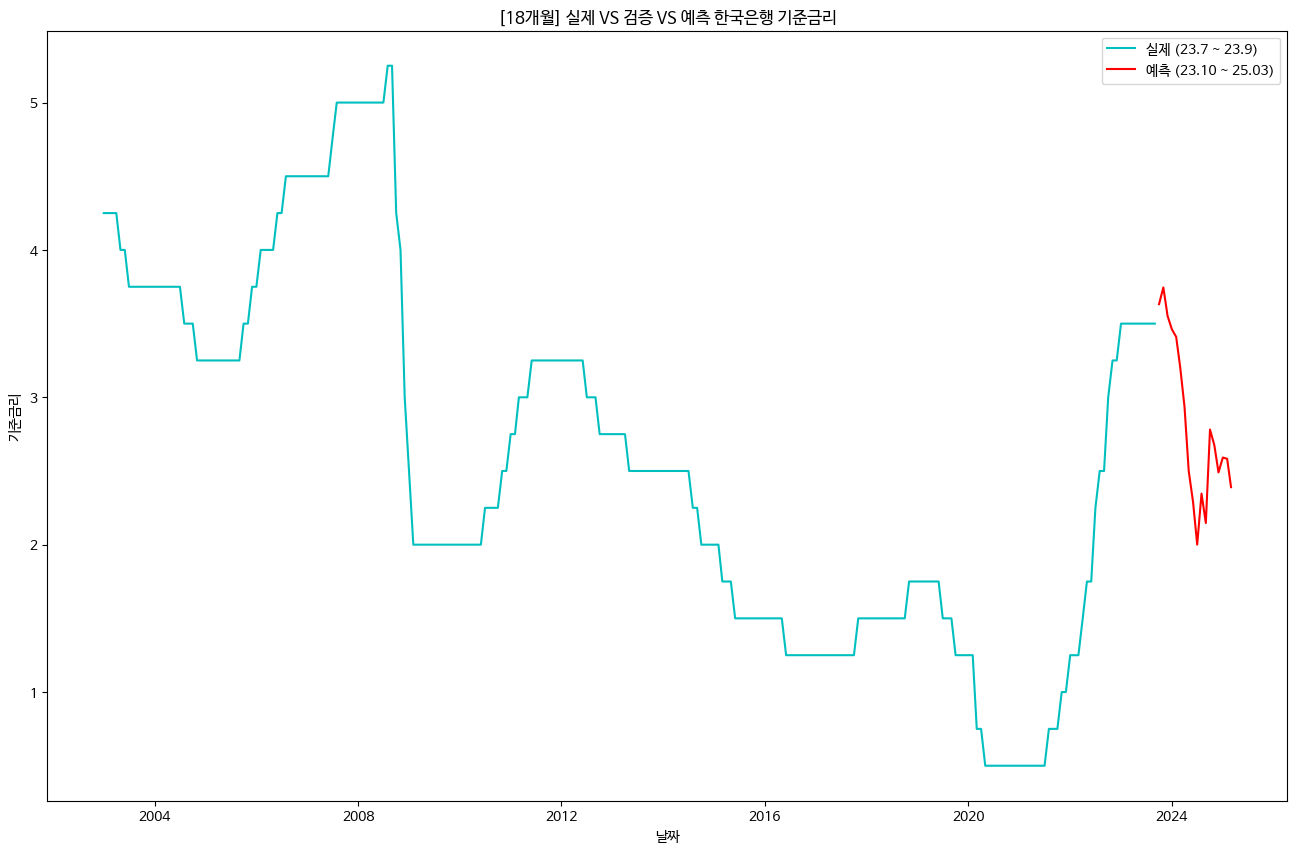

In [247]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_18['날짜'], for_plot_18['0.1'], label='예측 (23.10 ~ 25.03)', c = 'r')

plt.title('[18개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 24개월 단위 예측

- train test split

In [248]:
train = eco_df_for_ts.iloc[: 225, :]
test = eco_df_for_ts.iloc[225 :, :]

train.shape, test.shape

((225, 23), (24, 23))

In [249]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2021-05-01  0.787494  0.007937         0.390244  0.001894   
        2021-06-01  0.818217  0.017470         0.414634  0.005682   
        2021-07-01  0.943795  0.020825         0.439024  0.009470   
        2021-08-01  0.972652  0.020375         0.439024  0.007576   
        2021-09-01  0.975964  0.025105         0.463415  0.005682   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2021-05-01        0.810786  0.724266          -0.469770   
        2021-06-01        0.783484  0.724266          -0.469770   
        2021-07-01        0.752562  0.587643          -0.512435   
        2021-08-01        0.777364  0.587643          -0.539101   
        2021-09-01        0.756279  0.587643          -0.549768   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2021-05-01                   0.877289        0.544677     0.857143   
        2021-06-01                   0.976079        0.501863     0.857143   
        2021-07-01                   0.936563        0.479634     0.638095   
        2021-08-01                   0.867410        0.478997     0.638095   
        2021-09-01                   0.827894        0.491594     0.638095   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2021-05-01  ...     0.25   0.528594 -0.171364  0.631101    0.697509   
        2021-06-01  ...     0.23   0.630041 -0.028364  0.664758    0.736655   
        2021-07-01  ...     0.18   0.591913  0.199308  0.659239    0.713523   
        2021-08-01  ...     0.11   0.553145  0.285861  0.656190    0.603203   
        2021-09-01  ...     0.14   0.566103  0.516355  0.674124    0.485765   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [250]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135042'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.42 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.58 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 225 rows, 1 time series. Median time series length is 225 (min=225, max=225). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [251]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [252]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [253]:
# 원래값
test['기준금리']

225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [254]:
# 예측값
valid_24 = pred.reset_index()['0.9']

pred.reset_index()['0.9']

0     1.268027
1     1.360325
2     1.445816
3     1.552332
4     1.618027
5     1.690207
6     1.744576
7     1.782775
8     1.823192
9     1.853595
10    1.893759
11    1.937611
12    2.001584
13    2.057615
14    2.093134
15    2.168396
16    2.202016
17    2.234428
18    2.267092
19    2.286468
20    2.299562
21    2.315557
22    2.344434
23    2.412698
Name: 0.9, dtype: float64

In [255]:
pred

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2021-10-01  0.886830  0.522340  0.626331  0.727501  0.799122   
        2021-11-01  0.867613  0.390912  0.533421  0.662384  0.757442   
        2021-12-01  0.867557  0.304412  0.476510  0.626517  0.740118   
        2022-01-01  0.903122  0.268427  0.464189  0.632600  0.760642   
        2022-02-01  0.903924  0.205413  0.423424  0.607429  0.749196   
        2022-03-01  0.918208  0.162174  0.400054  0.598409  0.752522   
        2022-04-01  0.919599  0.110351  0.366715  0.577494  0.743847   
        2022-05-01  0.908245  0.049323  0.323036  0.546805  0.723819   
        2022-06-01  0.902068 -0.003653  0.286337  0.521332  0.707150   
        2022-07-01  0.889409 -0.060093  0.244868  0.490561  0.686487   
        2022-08-01  0.888826 -0.103027  0.216565  0.472744  0.676817   
        2022-09-01  0.892646 -0.138909  0.193620  0.460441  0.672550   
        2022-10-01  0.917738 -0.151402  0.194442  0.469478  0.690589   
        2022-11-01  0.938271 -0.168261  0.189467  0.474567  0.703948   
        2022-12-01  0.938215 -0.202833  0.166067  0.460342  0.695897   
        2023-01-01  0.979374 -0.196207  0.185014  0.486093  0.729048   
        2023-02-01  0.979411 -0.229351  0.163547  0.472645  0.722136   
        2023-03-01  0.978886 -0.262687  0.141632  0.459380  0.715728   
        2023-04-01  0.980328 -0.293148  0.122268  0.448340  0.710962   
        2023-05-01  0.969708 -0.334030  0.091549  0.425714  0.694562   
        2023-06-01  0.951631 -0.381917  0.053588  0.393092  0.671359   
        2023-07-01  0.938967 -0.423043  0.022307  0.367874  0.651724   
        2023-08-01  0.939416 -0.450256  0.004384  0.357968  0.646049   
        2023-09-01  0.979082 -0.439341  0.025322  0.386955  0.680076   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2021-10-01  0.886993  0.974928  1.046295  1.147584  1.268027  
        2021-11-01  0.867334  0.977082  1.072281  1.201511  1.360325  
        2021-12-01  0.866955  0.994176  1.107358  1.257756  1.445816  
        2022-01-01  0.901427  1.043015  1.171995  1.339913  1.552332  
        2022-02-01  0.902838  1.056757  1.199099  1.382631  1.618027  
        2022-03-01  0.918313  1.083149  1.237079  1.434870  1.690207  
        2022-04-01  0.919389  1.095449  1.260054  1.471408  1.744576  
        2022-05-01  0.908476  1.092863  1.268546  1.492225  1.782775  
        2022-06-01  0.902607  1.096954  1.281864  1.516493  1.823192  
        2022-07-01  0.889503  1.092740  1.286650  1.532326  1.853595  
        2022-08-01  0.889047  1.100750  1.303810  1.559498  1.893759  
        2022-09-01  0.891833  1.111517  1.324265  1.590258  1.937611  
        2022-10-01  0.916906  1.143398  1.364351  1.639957  2.001584  
        2022-11-01  0.938009  1.171608  1.398607  1.684496  2.057615  
        2022-12-01  0.937318  1.178125  1.413662  1.707227  2.093134  
        2023-01-01  0.978154  1.226688  1.469429  1.770673  2.168396  
        2023-02-01  0.977672  1.232458  1.483196  1.792466  2.202016  
        2023-03-01  0.977799  1.239350  1.494790  1.813634  2.234428  
        2023-04-01  0.979570  1.247049  1.509202  1.835994  2.267092  
        2023-05-01  0.967934  1.241671  1.512287  1.844221  2.286468  
        2023-06-01  0.949521  1.229514  1.505419  1.845644  2.299562  
        2023-07-01  0.937109  1.223605  1.504975  1.852247  2.315557  
        2023-08-01  0.936943  1.228534  1.517310  1.872598  2.344434  
        2023-09-01  0.976697  1.273573  1.568685  1.929547  2.412698

In [256]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[225:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[225: , :]

<ipython-input-257-cb6f687c7cb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


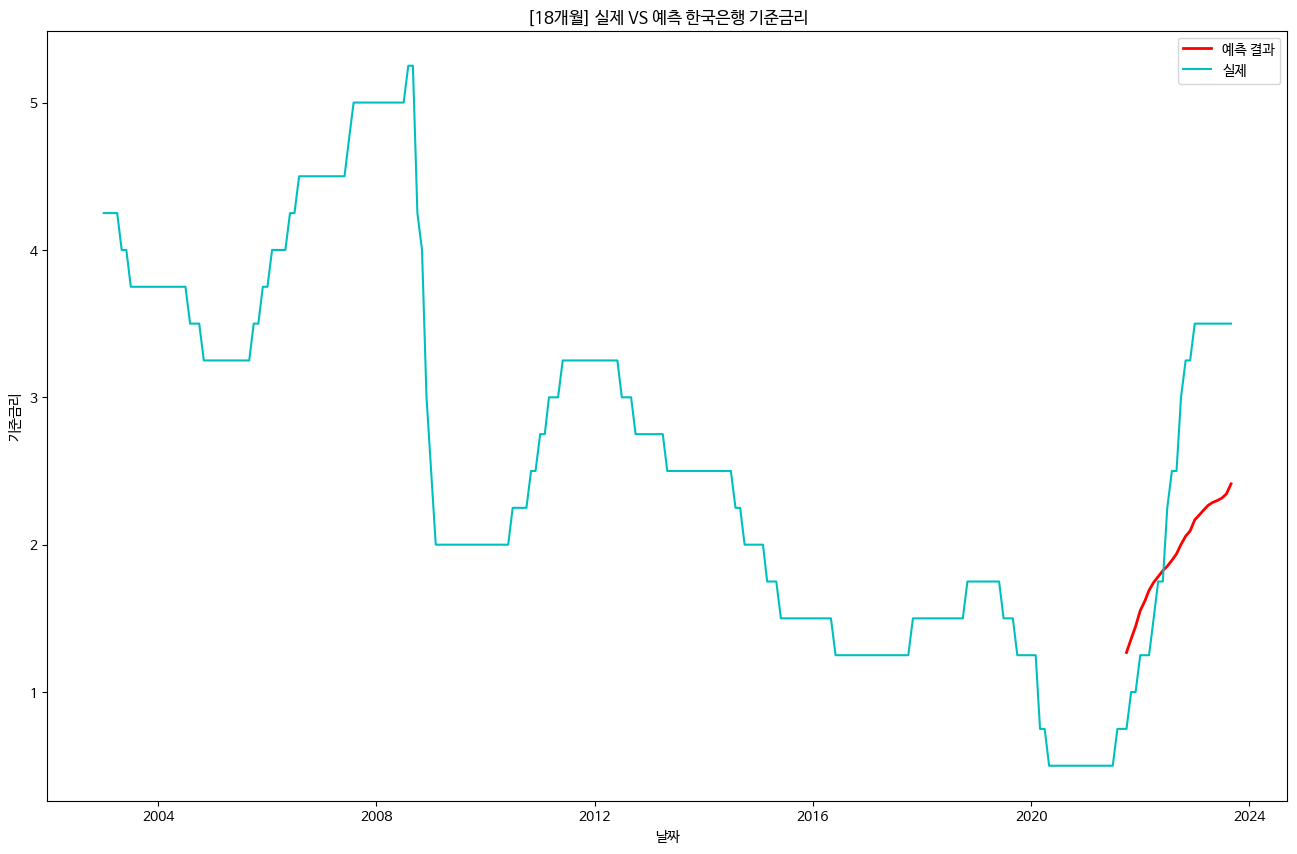

In [257]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [258]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135051'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.41 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.58 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [259]:
pred_24 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [260]:
pred_24

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  3.954387  3.445112  3.613864  3.665442  3.758125   
        2023-11-01  4.086228  3.561615  3.711385  3.784327  3.895265   
        2023-12-01  3.879131  3.321831  3.445724  3.583671  3.708617   
        2024-01-01  3.911082  3.285796  3.428856  3.580623  3.765988   
        2024-02-01  3.954238  3.247193  3.455749  3.571081  3.766850   
        2024-03-01  3.892372  3.075231  3.347664  3.522616  3.679179   
        2024-04-01  3.811575  3.023538  3.261399  3.397862  3.563075   
        2024-05-01  3.589625  2.785399  3.036327  3.230822  3.355476   
        2024-06-01  3.479935  2.530583  2.891006  3.094351  3.275177   
        2024-07-01  3.365074  2.443158  2.717966  2.881070  3.166270   
        2024-08-01  3.434112  2.441145  2.775604  2.995281  3.141449   
        2024-09-01  3.357801  2.415771  2.712168  2.890840  3.140730   
        2024-10-01  3.934562  2.878474  3.184989  3.468179  3.627081   
        2024-11-01  4.080420  3.091735  3.359375  3.600974  3.765874   
        2024-12-01  3.898833  2.832228  3.157873  3.406245  3.625545   
        2025-01-01  4.081473  3.000068  3.334798  3.589722  3.814619   
        2025-02-01  4.081411  2.991368  3.334904  3.596177  3.777889   
        2025-03-01  3.995987  2.880551  3.184026  3.451465  3.687055   
        2025-04-01  3.875036  2.667318  3.124943  3.349767  3.590481   
        2025-05-01  3.699458  2.414673  2.929009  3.208284  3.405378   
        2025-06-01  3.530108  2.233005  2.706629  2.991601  3.193562   
        2025-07-01  3.238367  2.050043  2.434159  2.676081  3.028629   
        2025-08-01  3.431362  2.118990  2.559257  2.855228  3.066587   
        2025-09-01  3.252194  1.941175  2.388820  2.690111  2.906017   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  3.896540  4.034955  4.176248  4.325049  4.542412  
        2023-11-01  4.002131  4.108997  4.317157  4.487322  4.734313  
        2023-12-01  3.828575  3.997145  4.122091  4.308649  4.529764  
        2024-01-01  3.945596  4.027981  4.164735  4.365114  4.605395  
        2024-02-01  3.858960  4.096903  4.292672  4.456615  4.811005  
        2024-03-01  3.828691  4.075426  4.280601  4.455552  4.727985  
        2024-04-01  3.720672  3.975491  4.189315  4.374389  4.660861  
        2024-05-01  3.520597  3.734329  4.004816  4.199312  4.498851  
        2024-06-01  3.447365  3.570943  3.800380  4.149559  4.461370  
        2024-07-01  3.345143  3.475406  3.760606  4.020932  4.344351  
        2024-08-01  3.423903  3.609135  3.901137  4.120813  4.358050  
        2024-09-01  3.380648  3.523343  3.773234  4.000517  4.296914  
        2024-10-01  3.824214  4.118570  4.374694  4.609272  5.158844  
        2024-11-01  4.017225  4.268576  4.579310  4.772298  5.185771  
        2024-12-01  3.833694  4.090455  4.406976  4.606737  4.980993  
        2025-01-01  4.076611  4.289993  4.563501  4.867036  5.250377  
        2025-02-01  3.996341  4.263405  4.590950  4.900834  5.292981  
        2025-03-01  3.910432  4.231031  4.515233  4.782671  5.231980  
        2025-04-01  3.818647  4.095423  4.384749  4.706795  5.115808  
        2025-05-01  3.638208  3.919649  4.262576  4.541851  4.910353  
        2025-06-01  3.430941  3.765543  4.113337  4.398309  4.871933  
        2025-07-01  3.221839  3.463661  3.670374  4.058130  4.490857  
        2025-08-01  3.409973  3.656137  4.013330  4.309301  4.846791  
        2025-09-01  3.205041  3.504065  3.817193  4.167095  4.566129

In [261]:
for_plot_24 = pred_24.reset_index()[['timestamp','0.3']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-262-6834ff8cf897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


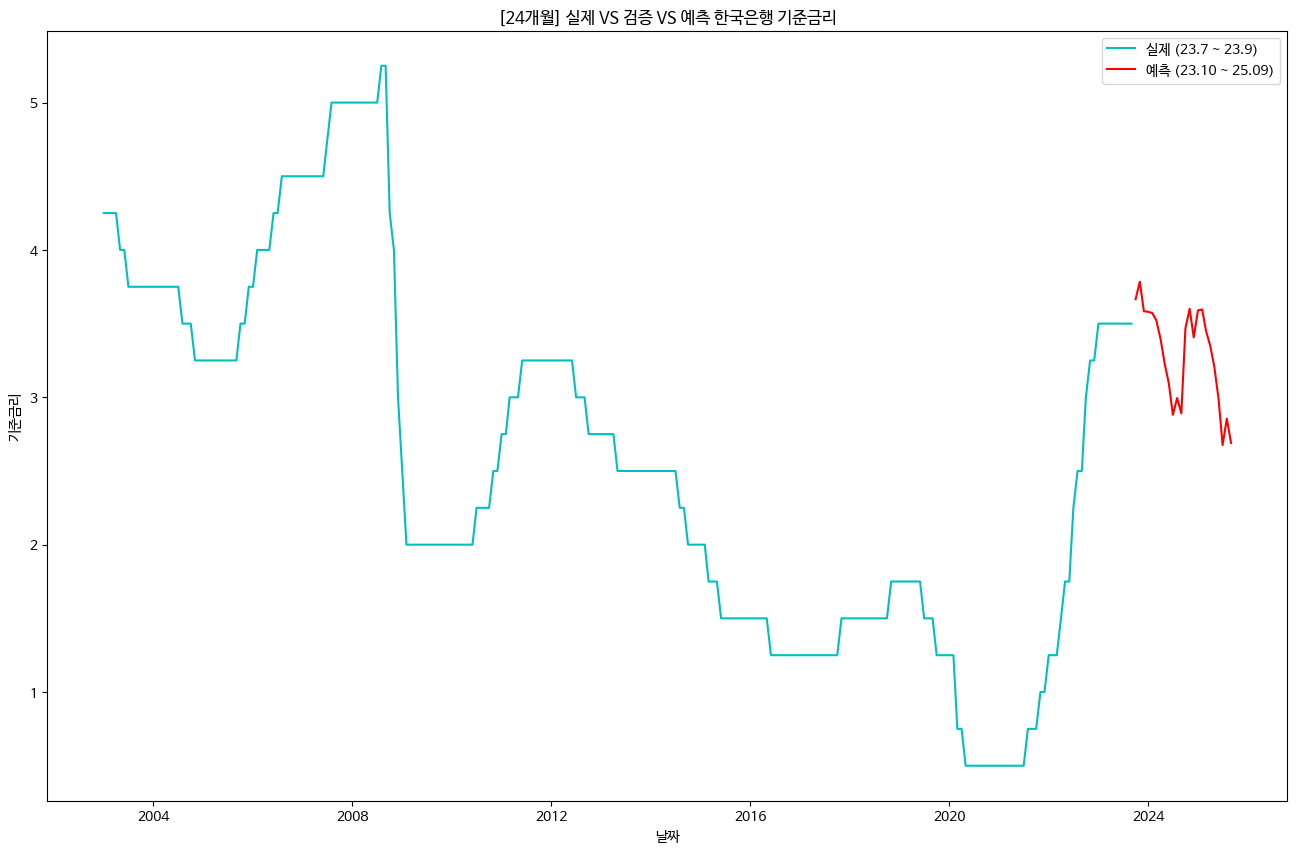

In [262]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_24['날짜'] = pd.to_datetime(for_plot_24['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_24['날짜'], for_plot_24['0.3'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[24개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 30개월 단위 예측

- train test split

In [263]:
train = eco_df_for_ts.iloc[: 219, :]
test = eco_df_for_ts.iloc[219 :, :]

train.shape, test.shape

((219, 23), (30, 23))

In [264]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2020-11-01  1.031235  0.010092         0.024390  0.007576   
        2020-12-01  0.844778  0.004124         0.024390  0.007576   
        2021-01-01  0.809978  0.003154         0.170732  0.007576   
        2021-02-01  0.855224  0.000000         0.219512  0.005682   
        2021-03-01  0.967543  0.006330         0.292683  0.003788   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2020-11-01        0.835604  0.451020          -0.347107   
        2020-12-01        0.870525  0.246086          -0.379106   
        2021-01-01        0.896561  0.246086          -0.437771   
        2021-02-01        0.872175  0.314397          -0.501769   
        2021-03-01        0.851723  0.451020          -0.539101   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2020-11-01                   0.274669        0.669003     0.180952   
        2020-12-01                   0.442612        0.661087     0.180952   
        2021-01-01                   0.580918        0.634154     0.476190   
        2021-02-01                   0.640192        0.606607     0.476190   
        2021-03-01                   0.600676        0.585286     0.476190   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2020-11-01  ...     0.14   0.175661 -0.212759  0.287036    0.530249   
        2020-12-01  ...     0.45   0.170598 -0.402798  0.301219    0.521352   
        2021-01-01  ...     1.00   0.133500 -0.097041  0.307898    0.549822   
        2021-02-01  ...     0.50   0.113539 -0.052824  0.335311    0.581851   
        2021-03-01  ...     0.27   0.175183  0.025262  0.421354    0.615658   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [265]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135102'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.42 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.57 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 219 rows, 1 time series. Median time series length is 219 (min=219, max=219). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [266]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [267]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [268]:
# 원래값
test['기준금리']

219    0.50
220    0.50
221    0.50
222    0.50
223    0.75
224    0.75
225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [269]:
# 예측값
valid_30 = pred.reset_index()['0.9']
pred.reset_index()['0.9']

0     1.253351
1     1.212417
2     1.293960
3     1.352653
4     1.368062
5     1.386844
6     1.403461
7     1.421388
8     1.434778
9     1.468891
10    1.473582
11    1.481894
12    1.435081
13    1.374082
14    1.441685
15    1.490044
16    1.495607
17    1.506515
18    1.512400
19    1.522216
20    1.530463
21    1.557935
22    1.558937
23    1.546940
24    1.480930
25    1.412075
26    1.476129
27    1.524053
28    1.529488
29    1.539780
Name: 0.9, dtype: float64

In [270]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[219:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[219: , :]

<ipython-input-271-00444e7a3544>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


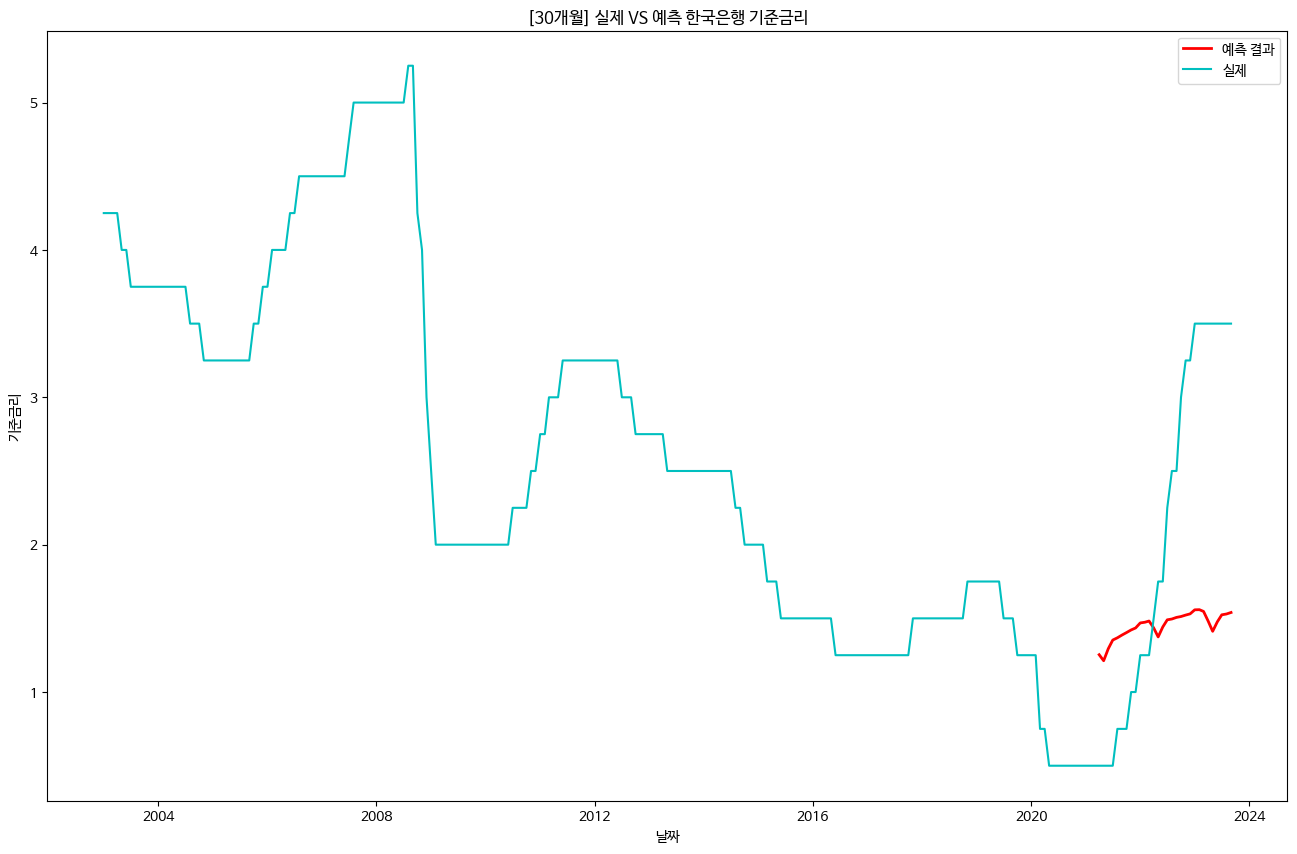

In [271]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[30개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [272]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="기준금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135111'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.43 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.57 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [273]:
pred_30 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [274]:
pred_30

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  4.330380  4.076467  4.160602  4.217703  4.275732   
        2023-11-01  4.535223  4.215139  4.319378  4.396791  4.456047   
        2023-12-01  4.351947  3.959623  4.093542  4.178476  4.267179   
        2024-01-01  4.366123  3.937733  4.073745  4.179883  4.263684   
        2024-02-01  4.386652  3.909883  4.061949  4.179663  4.281420   
        2024-03-01  4.317237  3.796897  3.963477  4.091657  4.202356   
        2024-04-01  4.188820  3.613310  3.817430  3.947169  4.066091   
        2024-05-01  3.900885  3.281040  3.505647  3.644345  3.770921   
        2024-06-01  3.739308  3.087167  3.315378  3.470554  3.604319   
        2024-07-01  3.484054  2.800168  3.047479  3.202547  3.335048   
        2024-08-01  3.830164  3.122314  3.363992  3.526629  3.673661   
        2024-09-01  3.718820  2.977641  3.237413  3.407282  3.568558   
        2024-10-01  4.536011  3.770197  4.031525  4.208330  4.383597   
        2024-11-01  4.728893  3.940471  4.202990  4.394534  4.567439   
        2024-12-01  4.533705  3.723540  3.994989  4.192973  4.363317   
        2025-01-01  4.766972  3.935515  4.207538  4.411750  4.595480   
        2025-02-01  4.830910  3.955307  4.259896  4.470145  4.650969   
        2025-03-01  4.745072  3.851192  4.155845  4.371955  4.557788   
        2025-04-01  4.630566  3.729541  4.034036  4.255848  4.438487   
        2025-05-01  4.366978  3.442875  3.755071  3.982435  4.169819   
        2025-06-01  3.974512  3.006514  3.342349  3.567065  3.775205   
        2025-07-01  3.452336  2.462168  2.805337  3.043405  3.239935   
        2025-08-01  3.599478  2.601491  2.943764  3.187002  3.387948   
        2025-09-01  3.148890  2.117485  2.474838  2.731198  2.952595   
        2025-10-01  3.593517  2.550889  2.907047  3.160297  3.385927   
        2025-11-01  3.508505  2.459245  2.814072  3.072177  3.293892   
        2025-12-01  3.182696  2.107177  2.468610  2.731478  2.965327   
        2026-01-01  3.383983  2.304413  2.664266  2.931810  3.153525   
        2026-02-01  3.373143  2.269937  2.636160  2.908296  3.150065   
        2026-03-01  3.275348  2.135357  2.523969  2.800620  3.038181   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  4.331025  4.378252  4.444346  4.501448  4.593647  
        2023-11-01  4.527561  4.599076  4.666396  4.751874  4.864178  
        2023-12-01  4.359205  4.443167  4.515740  4.616804  4.734593  
        2024-01-01  4.350075  4.452594  4.544460  4.666727  4.810803  
        2024-02-01  4.377056  4.480756  4.582512  4.708291  4.892615  
        2024-03-01  4.306350  4.418409  4.545237  4.673417  4.864190  
        2024-04-01  4.193901  4.305581  4.432568  4.562308  4.758363  
        2024-05-01  3.889756  4.016655  4.159360  4.306122  4.514601  
        2024-06-01  3.721808  3.863492  4.013386  4.168561  4.396772  
        2024-07-01  3.483086  3.606931  3.763625  3.934822  4.157940  
        2024-08-01  3.827745  3.965699  4.128860  4.299561  4.557369  
        2024-09-01  3.720352  3.856017  4.025358  4.195227  4.471128  
        2024-10-01  4.532867  4.682136  4.849338  5.042273  5.311665  
        2024-11-01  4.730103  4.884703  5.057608  5.241088  5.519736  
        2024-12-01  4.531124  4.698932  4.869275  5.075323  5.362902  
        2025-01-01  4.768262  4.932979  5.116709  5.320922  5.617138  
        2025-02-01  4.820507  4.998110  5.178934  5.405312  5.701836  
        2025-03-01  4.732007  4.922356  5.116253  5.332364  5.645081  
        2025-04-01  4.617260  4.804097  5.002865  5.232741  5.545301  
        2025-05-01  4.353027  4.544299  4.755876  4.983240  5.303500  
        2025-06-01  3.962737  4.158335  4.374539  4.607319  4.943155  
        2025-07-01  3.447820  3.639576  3.860299  4.098367  4.425407  
        2025-08

In [275]:
for_plot_30 = pred_30.reset_index()[['timestamp','0.1']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-276-613bf9c828f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


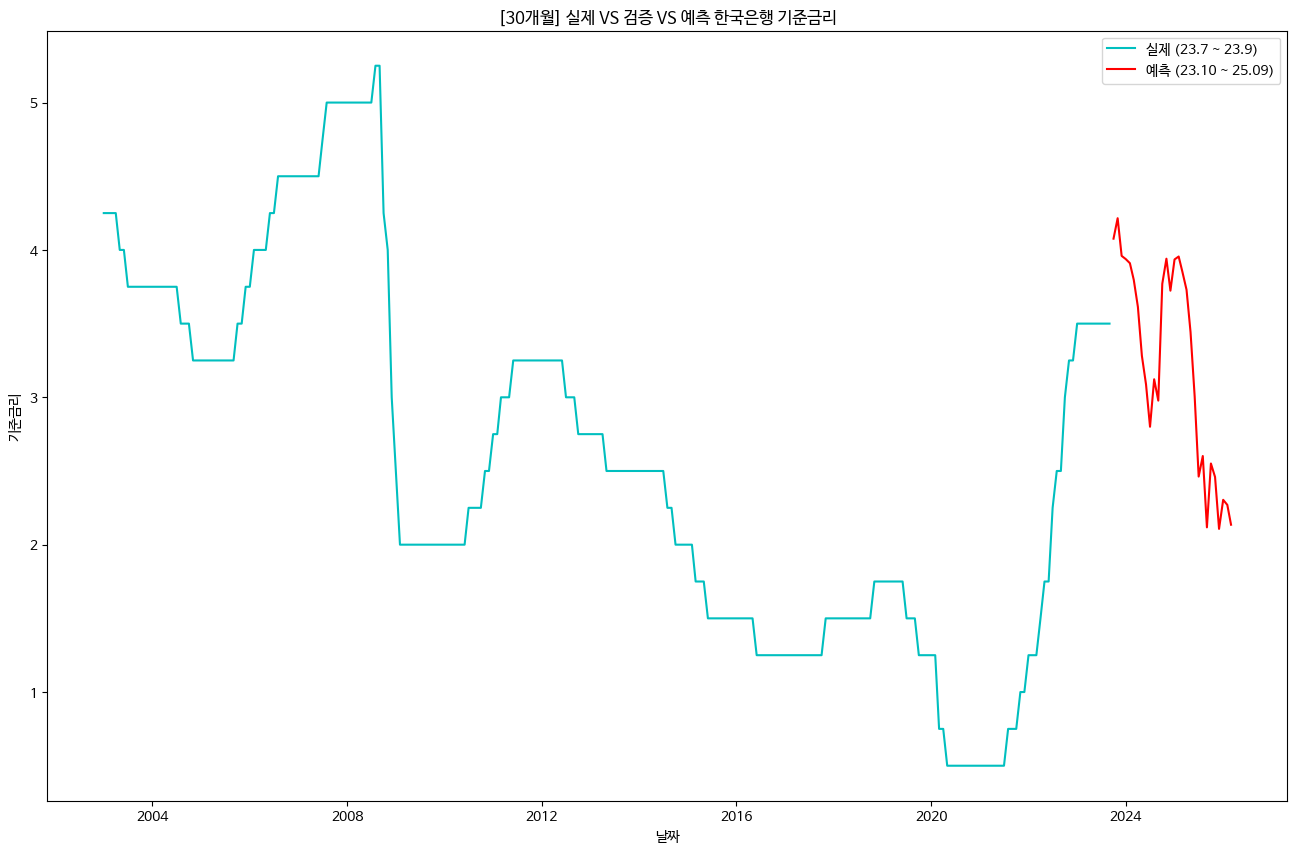

In [276]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_30['날짜'] = pd.to_datetime(for_plot_30['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_30['날짜'], for_plot_30['0.1'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[30개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 36개월 단위 예측

- train test split

In [277]:
train = eco_df_for_ts.iloc[: 213, :]
test = eco_df_for_ts.iloc[213 :, :]

train.shape, test.shape

((213, 23), (36, 23))

In [278]:
data = TimeSeriesDataFrame(train)
data

달러인덱스     미국채_2  소비자물가지수변화율(서비스)      미_금리  \
item_id timestamp                                                   
0       2003-01-01 -0.152880  0.325188         0.682927  0.225379   
        2003-02-01 -0.180872  0.302130         0.731707  0.229167   
        2003-03-01 -0.208015  0.291327         0.804878  0.227273   
        2003-04-01 -0.325919  0.301029         0.878049  0.229167   
        2003-05-01 -0.386992  0.259655         0.902439  0.229167   
...                      ...       ...              ...       ...   
        2020-05-01  1.753834  0.011033         0.024390  0.000000   
        2020-06-01  1.504641  0.013929         0.024390  0.005682   
        2020-07-01  1.421061  0.006575         0.024390  0.007576   
        2020-08-01  1.273213  0.004846         0.024390  0.009470   
        2020-09-01  1.222003  0.003895         0.048780  0.007576   

                    건설수주액(실질)(십억원)    현재생활형편  수출입물가비율(2015=100)  \
item_id timestamp                                                 
0       2003-01-01        0.226746  0.314397           2.410149   
        2003-02-01        0.218983  0.314397           2.447482   
        2003-03-01        0.207423  0.314397           2.490147   
        2003-04-01        0.203746 -2.554682           2.522146   
        2003-05-01        0.185016 -2.554682           2.570145   
...                            ...       ...                ...   
        2020-05-01        0.496695 -0.232094          -0.336440   
        2020-06-01        0.663711  0.109463          -0.363106   
        2020-07-01        0.845843  0.177774          -0.437771   
        2020-08-01        0.863002  0.177774          -0.437771   
        2020-09-01        0.776106 -0.095471          -0.384439   

                    기계류내수출하지수(선박제외)(2020=100)  건설기성액(실질)(십억원)  GDP 성장률 (%)  \
item_id timestamp                                                            
0       2003-01-01                  -0.970088        0.250147     0.647619   
        2003-02-01                  -1.098516        0.239756     0.647619   
        2003-03-01                  -1.217064        0.234879     0.647619   
        2003-04-01                  -1.345491        0.219194     0.466667   
        2003-05-01                  -1.434403        0.225174     0.466667   
...                                       ...             ...          ...   
        2020-05-01                  -0.209404        0.739878     0.000000   
        2020-06-01                  -0.258799        0.703853     0.000000   
        2020-07-01                  -0.298315        0.695226     0.161905   
        2020-08-01                  -0.229162        0.659641     0.161905   
        2020-09-01                  -0.080976        0.660818     0.161905   

                    ...  실_60세이상  미_coremom     원달러환율     미_yoy  재고순환지표(%p)  \
item_id timestamp   ...                                                       
0       2003-01-01  ...     0.03   0.224837 -0.555207  0.433008    0.435943   
        2003-02-01  ...     0.01   0.197885  0.607611  0.468688    0.427046   
        2003-03-01  ...     0.02   0.188977  1.180553  0.457591    0.411032   
        2003-04-01  ...     0.02   0.144580  0.810822  0.379543    0.332740   
        2003-05-01  ...     0.01   0.152907  0.722388  0.353746    0.291815   
...                 ...      ...        ...       ...       ...         ...   
        2020-05-01  ...     0.29   0.106606  1.029086  0.200626    0.313167   
        2020-06-01  ...     0.23   0.095022  0.695105  0.245579    0.286477   
        2020-07-01  ...     0.20   0.154166  0.585032  0.272950    0.298932   
        2020-08-01  ...     0.12   0.182065  0.552105  0.300028    0.341637   
        2020-09-01  ...     0.15   0.182775  0.379940  0.305758    0.391459   

                    동행지수순환변동치  코스피(1980.1.4=100)     미_실업률  경제위기  기준금리  
item_id timestamp                                                       
0       2003-01-01   1.062010          -2.143180  0.212389     1

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [279]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="기준금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135121'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.44 GB / 51.00 GB (91.1%)
Disk Space Avail:   128.56 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 213 rows, 1 time series. Median time series length is 213 (min=213, max=213). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [280]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [281]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: AutoARIMA_FULL


done


In [282]:
# 원래값
test['기준금리']

213    0.50
214    0.50
215    0.50
216    0.50
217    0.50
218    0.50
219    0.50
220    0.50
221    0.50
222    0.50
223    0.75
224    0.75
225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [283]:
# 예측값
valid_36 = pred.reset_index()['0.9']

pred.reset_index()

,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,2020-10-01,0.501699,0.331177,0.389714,0.431923,0.467989,0.501699,0.535409,0.571475,0.613684,0.672221
1,0,2020-11-01,0.494837,0.239278,0.327006,0.390264,0.444316,0.494837,0.545357,0.599409,0.662667,0.750395
2,0,2020-12-01,0.491653,0.125414,0.251136,0.341791,0.419252,0.491653,0.564054,0.641515,0.732170,0.857892
3,0,2021-01-01,0.490176,0.019444,0.181037,0.297556,0.397118,0.490176,0.583234,0.682796,0.799316,0.960908
4,0,2021-02-01,0.489491,-0.074821,0.118895,0.258579,0.377933,0.489491,0.601049,0.720403,0.860087,1.053804
5,0,2021-03-01,0.489173,-0.158772,0.063654,0.224039,0.361082,0.489173,0.617264,0.754307,0.914693,1.137119
6,0,2021-04-01,0.489026,-0.234405,0.013934,0.193004,0.346012,0.489026,0.632039,0.785048,0.964118,1.212457
7,0,2021-05-01,0.488958,-0.303424,-0.031416,0.164721,0.332313,0.488958,0.645602,0.813194,1.009331,1.281339
8,0,2021-06-01,0.488926,-0.367140,-0.073270,0.138630,0.319692,0.488926,0.658160,0.839221,1.051122,1.344992
9,0,2021-07-01,0.488911,-0.426537,-0.112283,0.114317,0.307938,0.488911,0.669884,0.863505,1.090105,1.404360


In [284]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[213:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[213: , :]

<ipython-input-285-b81c2ff55f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


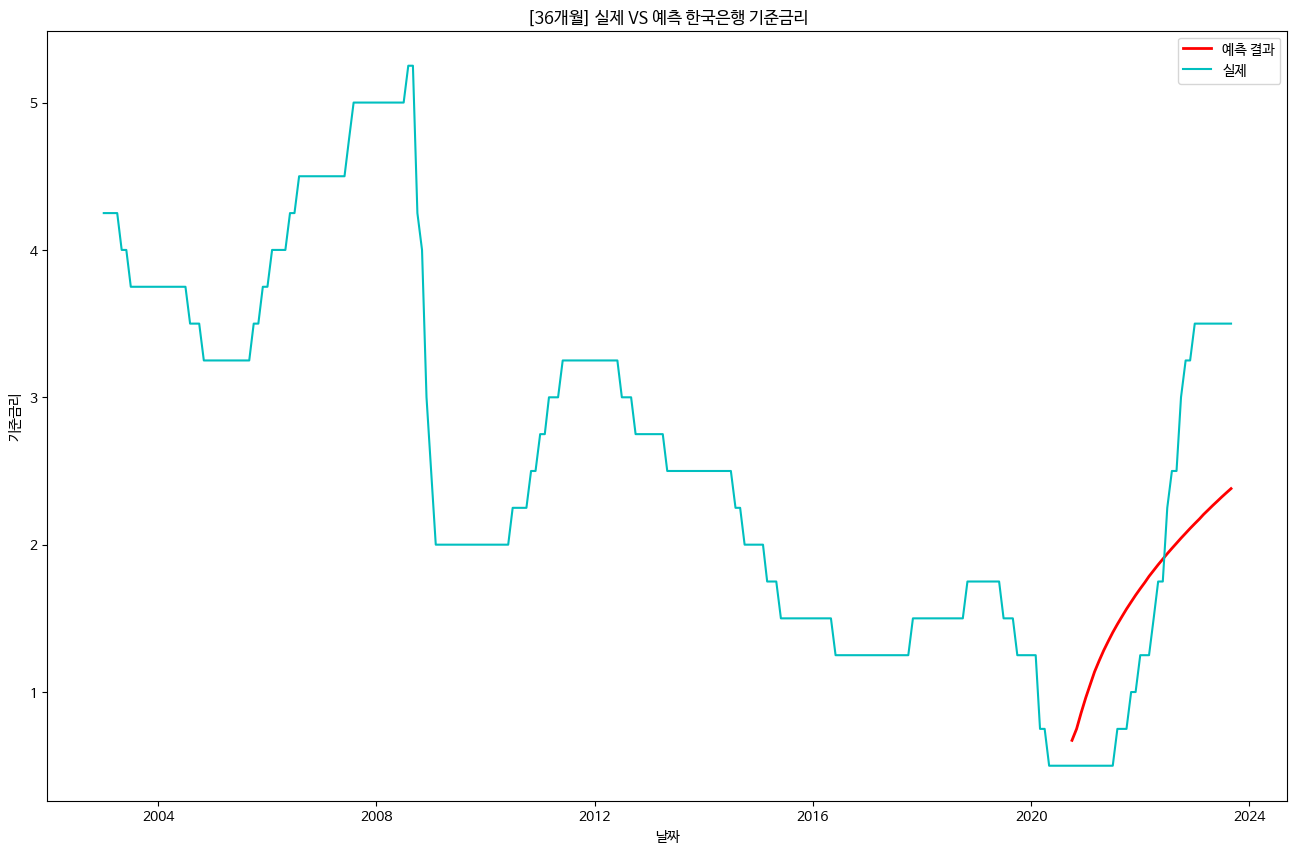

In [285]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[36개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [286]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_135129'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       46.43 GB / 51.00 GB (91.0%)
Disk Space Avail:   128.56 GB / 166.77 GB (77.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [287]:
pred_36 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [288]:
pred_36

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  2.638832  0.655867  1.700964  2.109833  2.382361   
        2023-11-01  2.645947  0.513503  1.609913  2.055782  2.359926   
        2023-12-01  2.646013  0.398870  1.534653  2.008914  2.337317   
        2024-01-01  2.740649  0.396811  1.565788  2.063983  2.412838   
        2024-02-01  2.713926  0.284898  1.483119  2.002402  2.369274   
        2024-03-01  2.717114  0.211069  1.435728  1.974075  2.357237   
        2024-04-01  2.726136  0.149264  1.398237  1.954115  2.352257   
        2024-05-01  2.714118  0.071325  1.342927  1.915122  2.327207   
        2024-06-01  2.773730  0.069020  1.361877  1.949398  2.374579   
        2024-07-01  2.688313 -0.074958  1.238001  1.840019  2.277585   
        2024-08-01  2.726258 -0.092713  1.239367  1.855172  2.304519   
        2024-09-01  2.710417 -0.161775  1.188575  1.817553  2.278157   
        2024-10-01  2.763540 -0.159696  1.208176  1.849789  2.321189   
        2024-11-01  2.858811 -0.113542  1.271191  1.924962  2.406750   
        2024-12-01  2.887363 -0.132382  1.268620  1.934122  2.425933   
        2025-01-01  2.895633 -0.169949  1.246788  1.923636  2.425142   
        2025-02-01  2.895760 -0.214248  1.217739  1.905584  2.416486   
        2025-03-01  2.905177 -0.247968  1.198828  1.897350  2.417376   
        2025-04-01  2.895430 -0.299669  1.161528  1.870435  2.399335   
        2025-05-01  2.874808 -0.361155  1.114070  1.833092  2.370635   
        2025-06-01  2.855690 -0.420128  1.068778  1.797665  2.343637   
        2025-07-01  2.690496 -0.624238  0.878028  1.616548  2.170751   
        2025-08-01  2.763737 -0.589038  0.926286  1.674222  2.236471   
        2025-09-01  2.589193 -0.800806  0.727296  1.484446  2.054568   
        2025-10-01  2.660958 -0.765497  0.775120  1.541294  2.119126   
        2025-11-01  2.857016 -0.605172  0.947711  1.722730  2.308120   
        2025-12-01  2.971933 -0.525307  1.039609  1.823305  2.416109   
        2026-01-01  2.963493 -0.568157  1.008572  1.800785  2.400866   
        2026-02-01  3.073218 -0.492232  1.096099  1.896679  2.503909   
        2026-03-01  3.109375 -0.489297  1.110439  1.919242  2.533499   
        2026-04-01  3.099015 -0.532330  1.078622  1.895512  2.516680   
        2026-05-01  3.180184 -0.483311  1.138677  1.963525  2.591493   
        2026-06-01  3.174195 -0.520951  1.111902  1.944585  2.579247   
        2026-07-01  3.135532 -0.590790  1.052765  1.893165  2.534421   
        2026-08-01  3.122464 -0.634578  1.019522  1.867526  2.515280   
        2026-09-01  3.082817 -0.704510  0.959987  1.815487  2.469645   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  2.638832  2.895303  3.167832  3.576701  4.621797  
        2023-11-01  2.645947  2.931967  3.236111  3.681981  4.778390  
        2023-12-01  2.646012  2.954708  3.283111  3.757371  4.893154  
        2024-01-01  2.740649  3.068460  3.417314  3.915510  5.084486  
        2024-02-01  2.713926  3.058578  3.425451  3.944733  5.142954  
        2024-03-01  2.717114  3.076992  3.460154  3.998501  5.223160  
        2024-04-01  2.726136  3.100015  3.498157  4.054035  5.303007  
        2024-05-01  2.714118  3.101029  3.513114  4.085310  5.356912  
        2024-06-01  2.773730  3.172881  3.598061  4.185583  5.478440  
        2024-07-01  2.688313  3.099041  3.536607  4.138625  5.451584  
        2024-08-01  2.726258  3.147997  3.597344  4.213149  5.545229  
        2024-09-01  2.710417  3.142677  3.603280  4.232258  5.582608  
        2024-10-01  2.763540  3.205891  3.677291  4.318904  5.686777  
        2024-11-01  2.858811  3.310872  3.792660  4.446431  5.831164  
        2024-12-01  2.887363  3.348793  3.840605  4.506107  5.907109  
        2025-01-01  2.895633  3.366124  3.867631  4.544479  5.961215  
        2

In [289]:
for_plot_36 = pred_36.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-290-cc58d0a5e5bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


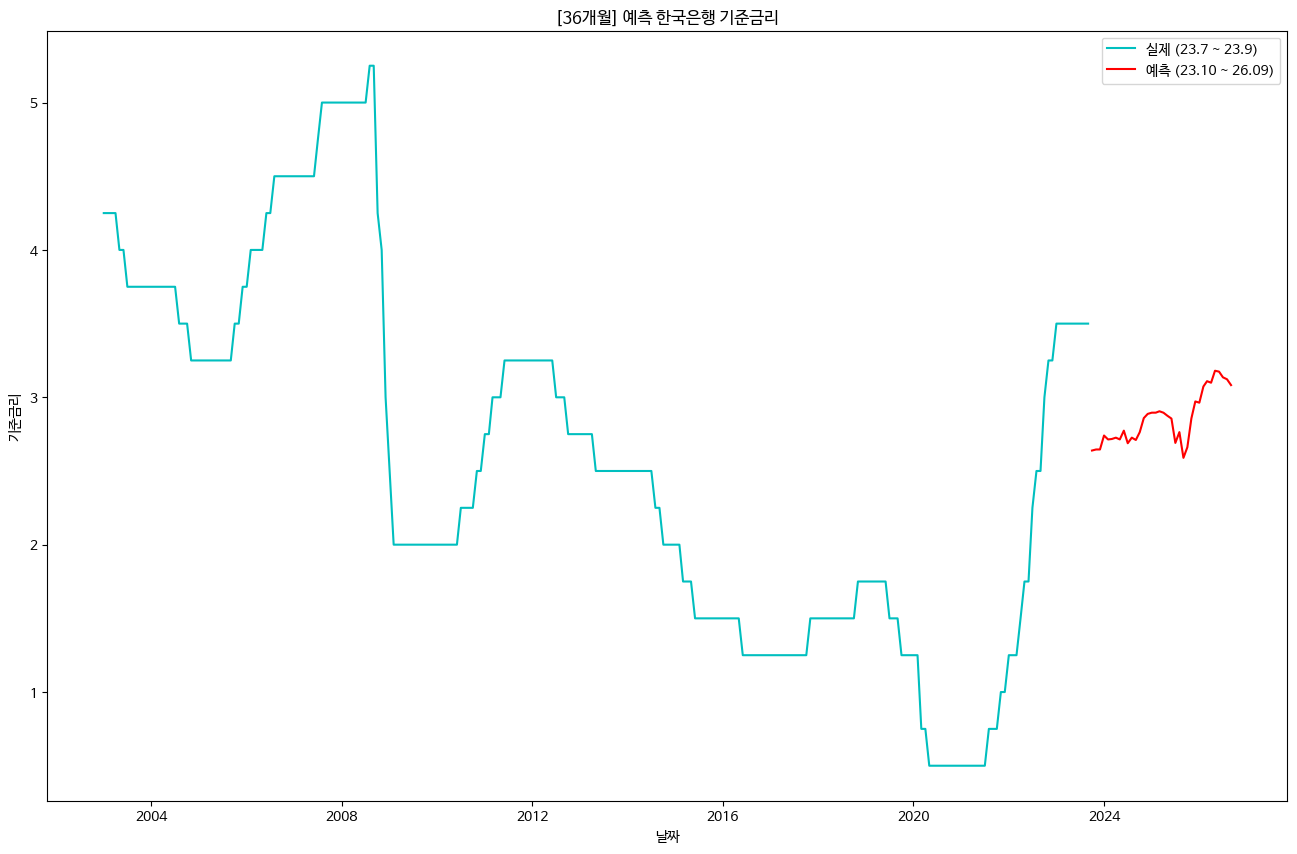

In [290]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_36['날짜'] = pd.to_datetime(for_plot_36['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_36['날짜'], for_plot_36['mean'], label='예측 (23.10 ~ 26.09)', c = 'r')

plt.title('[36개월] 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

# [3] 최종 결과 저장

- 36개월간 예측 결과


In [291]:
a = for_plot_36.merge(for_plot_30, how = 'left', on = '날짜').merge(for_plot_24, how = 'left', on='날짜').rename(columns = {'mean' : 'mean_36', '0.1' : 'mean_30', '0.3' : 'mean_24'})

In [292]:
b = a.merge(for_plot_18, how = 'left', on = '날짜').merge(for_plot_12, how = 'left', on = '날짜').merge(for_plot_6, how = 'left', on = '날짜').rename(columns = {'0.1' : 'mean_18', 'mean_x' : 'mean_12', 'mean_y' : 'mean_6'})
c = b.merge(for_plot_3, how = 'left', on = '날짜').rename(columns = {'mean':'mean_3'})

In [293]:
c

,날짜,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,2023-10-01,2.638832,4.076467,3.665442,3.632323,3.611118,3.512280,3.499402
1,2023-11-01,2.645947,4.215139,3.784327,3.745596,3.646149,3.513914,3.499449
2,2023-12-01,2.646013,3.959623,3.583671,3.553075,3.479068,3.511042,3.495574
3,2024-01-01,2.740649,3.937733,3.580623,3.461424,3.626589,3.515321,NaN
4,2024-02-01,2.713926,3.909883,3.571081,3.409974,3.643641,3.517859,NaN
5,2024-03-01,2.717114,3.796897,3.522616,3.203506,3.616816,3.517821,NaN
6,2024-04-01,2.726136,3.613310,3.397862,2.934597,3.501292,NaN,NaN
7,2024-05-01,2.714118,3.281040,3.230822,2.500344,3.243704,NaN,NaN
8,2024-06-01,2.773730,3.087167,3.094351,2.291230,2.402579,NaN,NaN
9,2024-07-01,2.688313,2.800168,2.881070,2.000455,1.626975,NaN,NaN


In [294]:
c.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/autogluon_result.csv', index = False)

- 36개월간 validation 저장

In [295]:
val_result_ag = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag.csv', encoding = 'cp949')

In [296]:
val_result_ag.iloc[-3:, -1] = valid_3
val_result_ag.iloc[-6:, -2] = valid_6
val_result_ag.iloc[-12:, -3] = valid_12
val_result_ag.iloc[-18:, -4] = valid_18
val_result_ag.iloc[-24:, -5] = valid_24
val_result_ag.iloc[-30:, -6] = valid_30
val_result_ag.iloc[-36:, -7] = valid_36

In [297]:
val_result_ag

,Unnamed: 0.1,Unnamed: 0,날짜,기준금리,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,0,0,2020-10-01,0.50,0.672221,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-11-01,0.50,0.750395,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2020-12-01,0.50,0.857892,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2021-01-01,0.50,0.960908,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2021-02-01,0.50,1.053804,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,2021-03-01,0.50,1.137119,NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,2021-04-01,0.50,1.212457,1.253351,NaN,NaN,NaN,NaN,NaN
7,7,7,2021-05-01,0.50,1.281339,1.212417,NaN,NaN,NaN,NaN,NaN
8,8,8,2021-06-01,0.50,1.344992,1.293960,NaN,NaN,NaN,NaN,NaN
9,9,9,2021-07-01,0.50,1.404360,1.352653,NaN,NaN,NaN,NaN,NaN


In [298]:
val_result_ag.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag.csv', encoding = 'cp949', index = False)